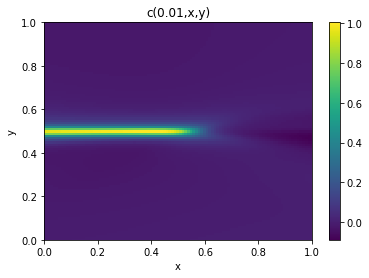

In [16]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
data =scipy.io.loadmat('pred_c.mat')
x = data['x']
y = data['y']
X,Y = np.meshgrid(x,y)
c = data['c']
plt.pcolormesh(X, Y, c[:,:], shading='auto')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('y', fontsize=10)
plt.xlabel('x', fontsize=10)
plt.title('c(0.01,x,y)')
plt.colorbar()
plt.savefig('c(0.01,x,y).png')
plt.show()

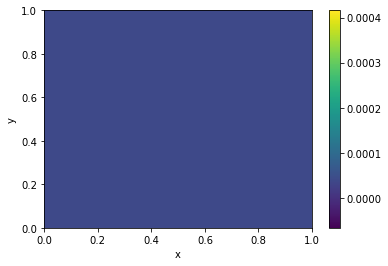

In [110]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
data =scipy.io.loadmat('pred.mat')
x = data['x']
y = data['y']
X,Y = np.meshgrid(x,y)
u1 = data['u1']
plt.pcolormesh(X, Y, u1[:,:], shading='auto')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('y', fontsize=10)
plt.xlabel('x', fontsize=10)
#plt.title('u1(0.01,x,y)')
plt.colorbar()
plt.savefig('u1(0.01,x,y).png')
plt.show()

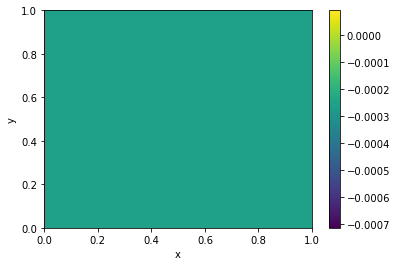

In [111]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
data =scipy.io.loadmat('pred.mat')
x = data['x']
y = data['y']
X,Y = np.meshgrid(x,y)
u2 = data['u2']
plt.pcolormesh(X, Y, u2[:,:], shading='auto')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('y', fontsize=10)
plt.xlabel('x', fontsize=10)
#plt.title('v(0.01,x,y)')
plt.colorbar()
plt.savefig('u2(0.01,x,y).png')
plt.show()

In [20]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import skopt
from distutils.version import LooseVersion
from scipy.io import loadmat

dde.config.set_default_float("float64")


def quasirandom(n_samples, sampler):
    space = [(-1.0, 1.0), (0.0, 1.0)]
    if sampler == "LHS":
        sampler = skopt.sampler.Lhs(
            lhs_type="centered", criterion="maximin", iterations=1000
        )
    elif sampler == "Halton":
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)
    elif sampler == "Hammersley":
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which
        # are too special and may cause some error.
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"):
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False)
        else:
            sampler = skopt.sampler.Sobol(skip=0, randomize=False)
            return np.array(
                sampler.generate(space, n_samples + 2)[2:]
            )
    return np.array(sampler.generate(space, n_samples))


def gen_testdata():
    data = loadmat("usol_D_0.001_k_5.mat")

    t = data["t"]

    x = data["x"]

    u = data["u"]

    dt = dx = 0.01

    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y


def main(NumDomain, method):
    def pde(x, y):
        u = y
        du_xx = dde.grad.hessian(y, x, i=0, j=0)
        du_t = dde.grad.jacobian(y, x, j=1)
        return du_t - 0.001 * du_xx + 5 * (u ** 3 - u)

    geom = dde.geometry.Interval(-1, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    if method == 'Grid':
        data = dde.data.TimePDE(geomtime, pde, [], num_domain=NumDomain, train_distribution='uniform')
    elif method == 'Random':
        data = dde.data.TimePDE(geomtime, pde, [], num_domain=NumDomain, train_distribution='pseudo')
    elif method in ['LHS', 'Halton', 'Hammersley', 'Sobol']:
        sample_pts = quasirandom(NumDomain, method)
        data = dde.data.TimePDE(geomtime, pde, [], num_domain=0, train_distribution='uniform', anchors=sample_pts)

    net = dde.maps.FNN([2] + [64] * 3 + [1], "tanh", "Glorot normal")

    def output_transform(x, y):
        x_in = x[:, 0:1]
        t_in = x[:, 1:2]
        return t_in * (1 + x_in) * (1 - x_in) * y + tf.square(x_in) * tf.cos(np.pi * x_in)

    net.apply_output_transform(output_transform)

    model = dde.Model(data, net)

    model.compile("adam", lr=1e-3)
    model.train(epochs=15000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    X, y_true = gen_testdata()
    y_pred = model.predict(X)
    error = dde.metrics.l2_relative_error(y_true, y_pred)
    print("L2 relative error:", error)
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    return error


if __name__ == "__main__":
    main(NumDomain=5000, method='Grid')
    # main(NumDomain=5000, method='Random')
    # main(NumDomain=5000, method='LHS')
    # main(NumDomain=5000, method='Halton')
    # main(NumDomain=5000, method='Hammersley')
    # main(NumDomain=5000, method='Sobol')


ModuleNotFoundError: No module named 'deepxde'

In [2]:
import torch
import numpy as np

def latin_hypercube(n, dim):
    # 生成拉丁超立方抽样矩阵
    boundaries = torch.linspace(0, 1, n+1)[:-1]
    points = boundaries + (1./n)*torch.rand(n, dim)
    for i in range(dim):
        points[:, i] = torch.randperm(n)
        points[:, i] = (points[:, i] - 0.5) / n
    return points

# 设置抽样点数和维度
n = 100
dim = 3

# 生成拉丁超立方抽样矩阵
lhs_points = latin_hypercube(n, dim)

# 将抽样点映射到 x[0,1] y[0,1] t[0,0.5] 区间
lhs_points[:, 0] *= 1
lhs_points[:, 1] *= 1
lhs_points[:, 2] *= 0.5

# 打印抽样结果
print(lhs_points)


RuntimeError: The size of tensor a (100) must match the size of tensor b (3) at non-singleton dimension 1

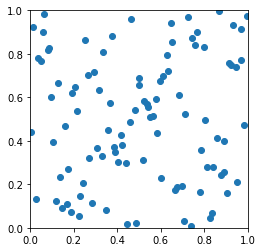

In [6]:
import torch
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt

def latin_hypercube_sampling(n, d):
    # 初始化采样点矩阵
    samples = torch.zeros((n, d))

    # 生成均匀分布采样点矩阵
    for i in range(d):
        samples[:, i] = torch.randperm(n)

    # 将采样点映射到[0, 1]上
    samples = (samples + torch.rand((n, d))) / n

    # 对每一维采样点进行随机置换
    for i in range(d):
        idx = torch.randperm(n)
        samples[:, i] = samples[idx, i]

    return samples

# 生成采样点
n = 100
d = 2
samples = latin_hypercube_sampling(n, d)
savemat('samples.mat', {'samples': samples})

# 绘制采样点图
fig, ax = plt.subplots()
ax.scatter(samples[:, 0], samples[:, 1])
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal', adjustable='box')
plt.show()


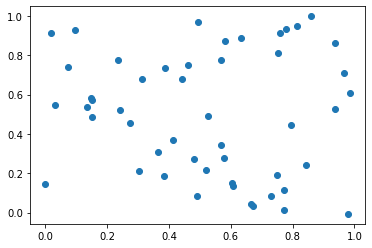

In [5]:
import torch
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt

def latin_hypercube(n):
    """
    生成拉丁超立方样本
    :param n: 样本数目
    :return: n 个拉丁超立方样本点
    """
    x = np.linspace(0, 1, n)
    
    samples = []
    for i in range(n):
        sample = x + (np.random.rand(n)-0.5)/n
        np.random.shuffle(sample)
        samples.append(sample)
    return np.array(samples)

# 生成 50 个拉丁超立方样本点
samples = latin_hypercube(50)

# 将样本点保存到 .mat 文件中
savemat('samples.mat', {'samples': samples})

# 绘制样本点的分布
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()


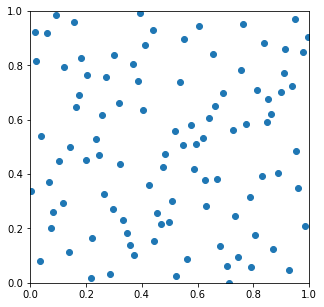

In [10]:
import numpy as np
from pyDOE import lhs
import scipy.io
import matplotlib.pyplot as plt

# 设置采样点数量
n_samples = 100

# 生成拉丁超立方抽样
lhs_points = lhs(2, samples=n_samples, criterion='maximin')

# 将抽样点转换到指定的区间
x_min, x_max = 0, 1
y_min, y_max = 0, 1
x = x_min + (x_max - x_min) * lhs_points[:, 0]
y = y_min + (y_max - y_min) * lhs_points[:, 1]

# 保存采样点的坐标到.mat文件
scipy.io.savemat('samples.mat', {'x': x, 'y': y})

# 生成采样图
fig = plt.figure(figsize=(5,5))
plt.scatter(x, y)
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()


In [21]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

data = scipy.io.loadmat('pred.mat')
x = data['x']
y = data['y']
X, Y = np.meshgrid(x, y)
P_1 = data['P1']
P_2 = data['P2']

# 绘制矢量场图
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.quiver(X, Y, P_1, P_2, color='b', scale=0.05)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('P')
plt.savefig('P.png')
plt.show()


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


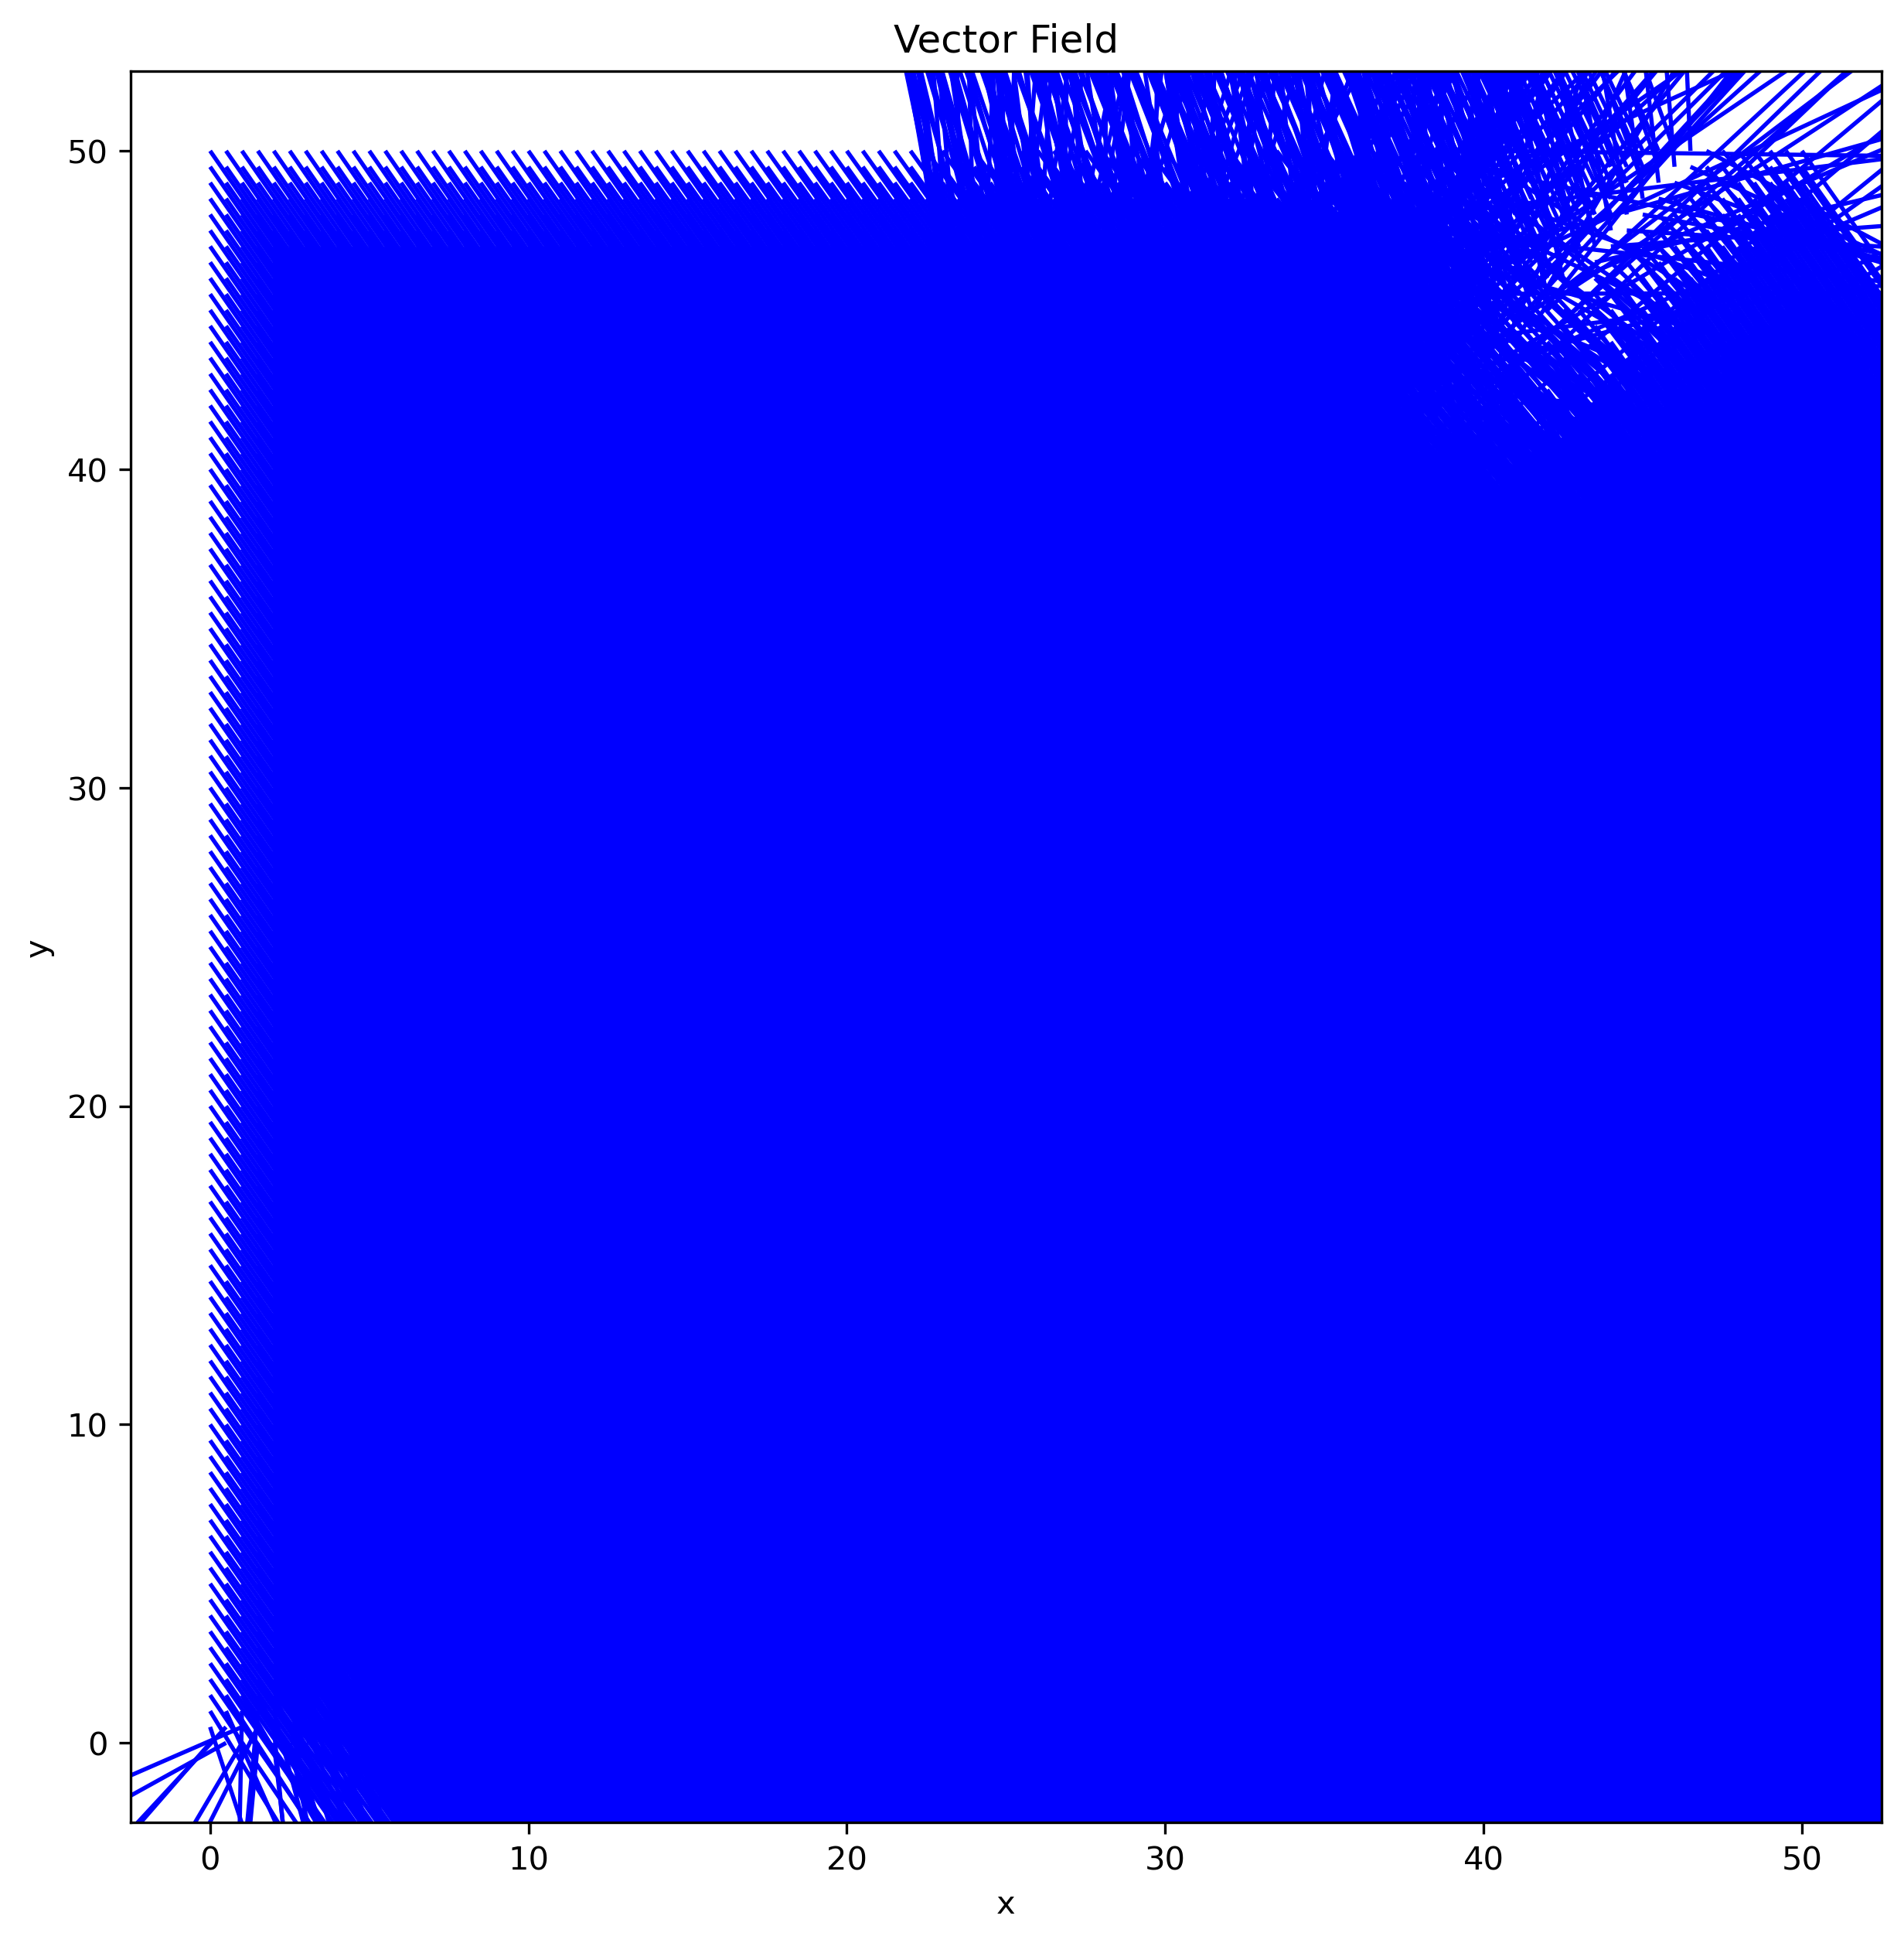

In [22]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

data = scipy.io.loadmat('pred.mat')
x = data['x']
y = data['y']
u_1 = data['u1']
u_2 = data['u2']
P_1 = data['P1']
P_2 = data['P2']

# 计算矢量大小和分量
vmag = np.sqrt(P_1**2 + P_2**2)
u = P_1 / vmag
v = P_2 / vmag

# 绘制矢量场图
plt.figure(figsize=(10, 10), dpi=300)
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
plt.quiver(x[::quiverSkip, ::quiverSkip], y[::quiverSkip, ::quiverSkip], u[::quiverSkip, ::quiverSkip], v[::quiverSkip, ::quiverSkip],color='b', scale=0.005 )
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field')
plt.xlim((0, 50))
plt.ylim((0, 50))
plt.axis('scaled')
plt.savefig('vector_field.png')
plt.show()


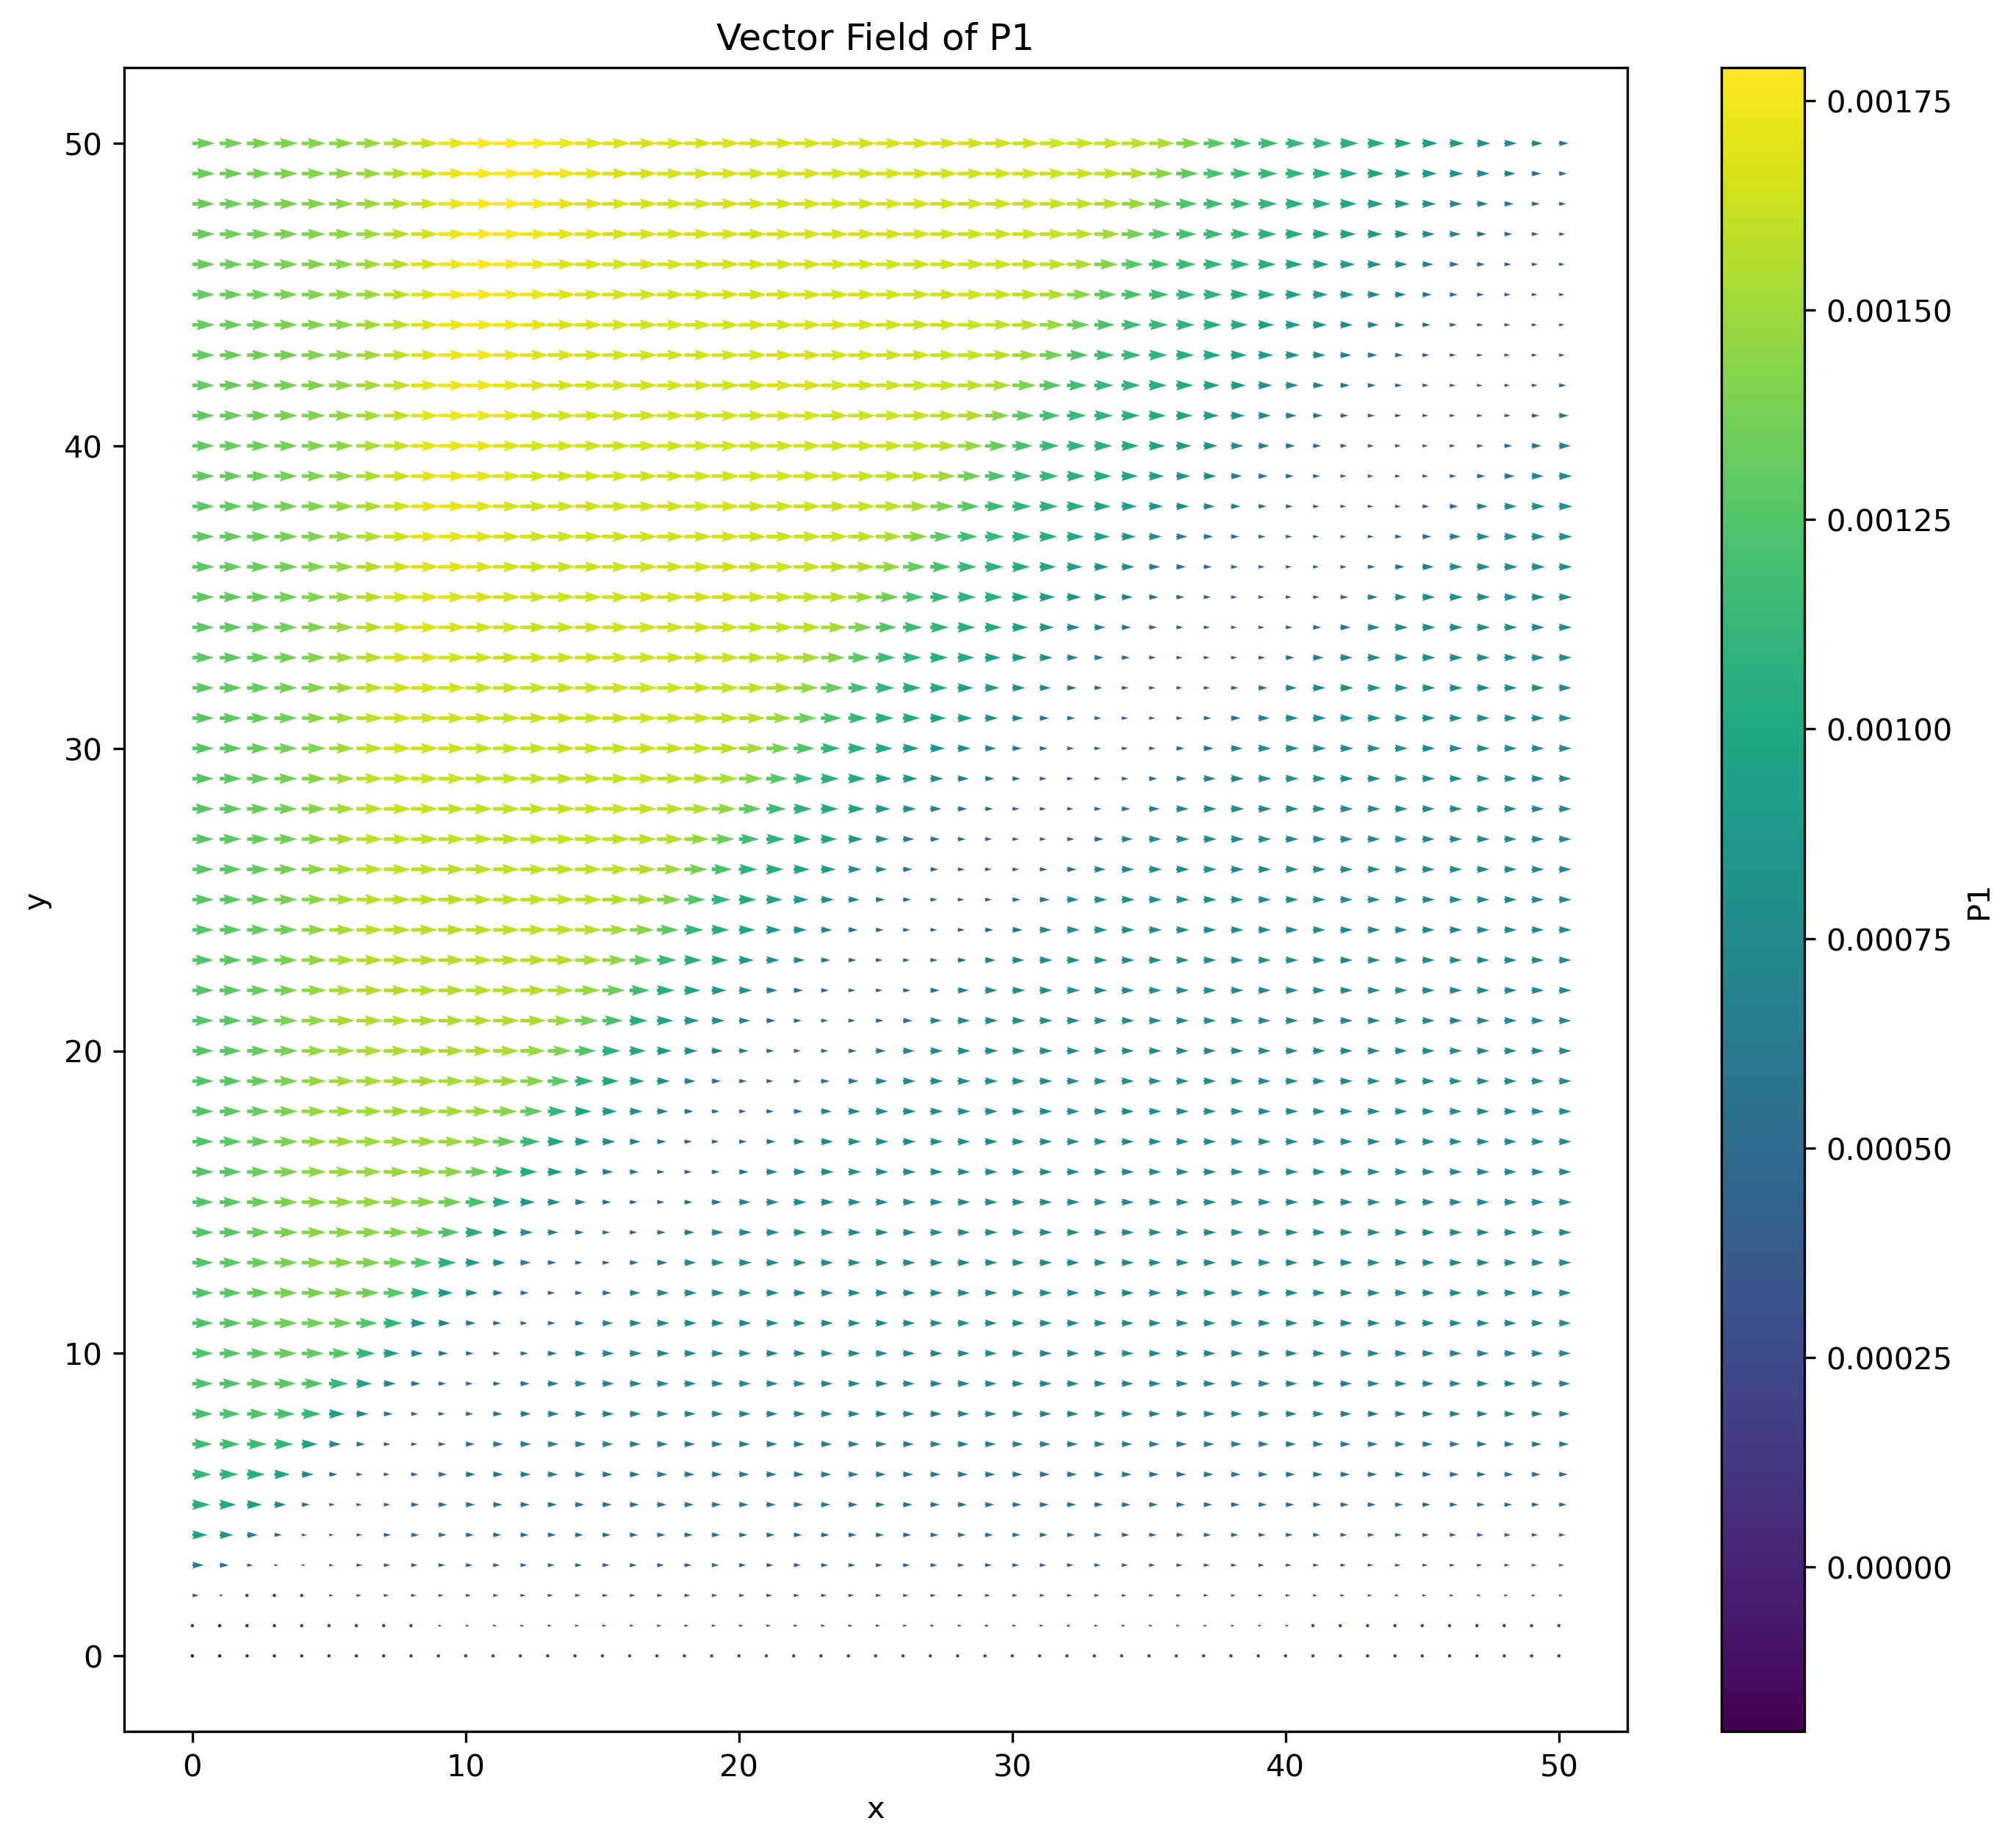

In [26]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 加载pred.mat文件
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']

# 创建网格坐标
x = data['x']
y = data['y']
X, Y = np.meshgrid(x, y)

# 计算矢量的大小和方向
U = P1_pred * np.cos(P1_pred)
V = P1_pred * np.sin(P1_pred)

# 绘制矢量场图
plt.figure(figsize=(11, 10), dpi=300)
plt.quiver(X, Y, U, V, P1_pred, cmap='viridis')
plt.colorbar(label='P1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P1')
plt.show()


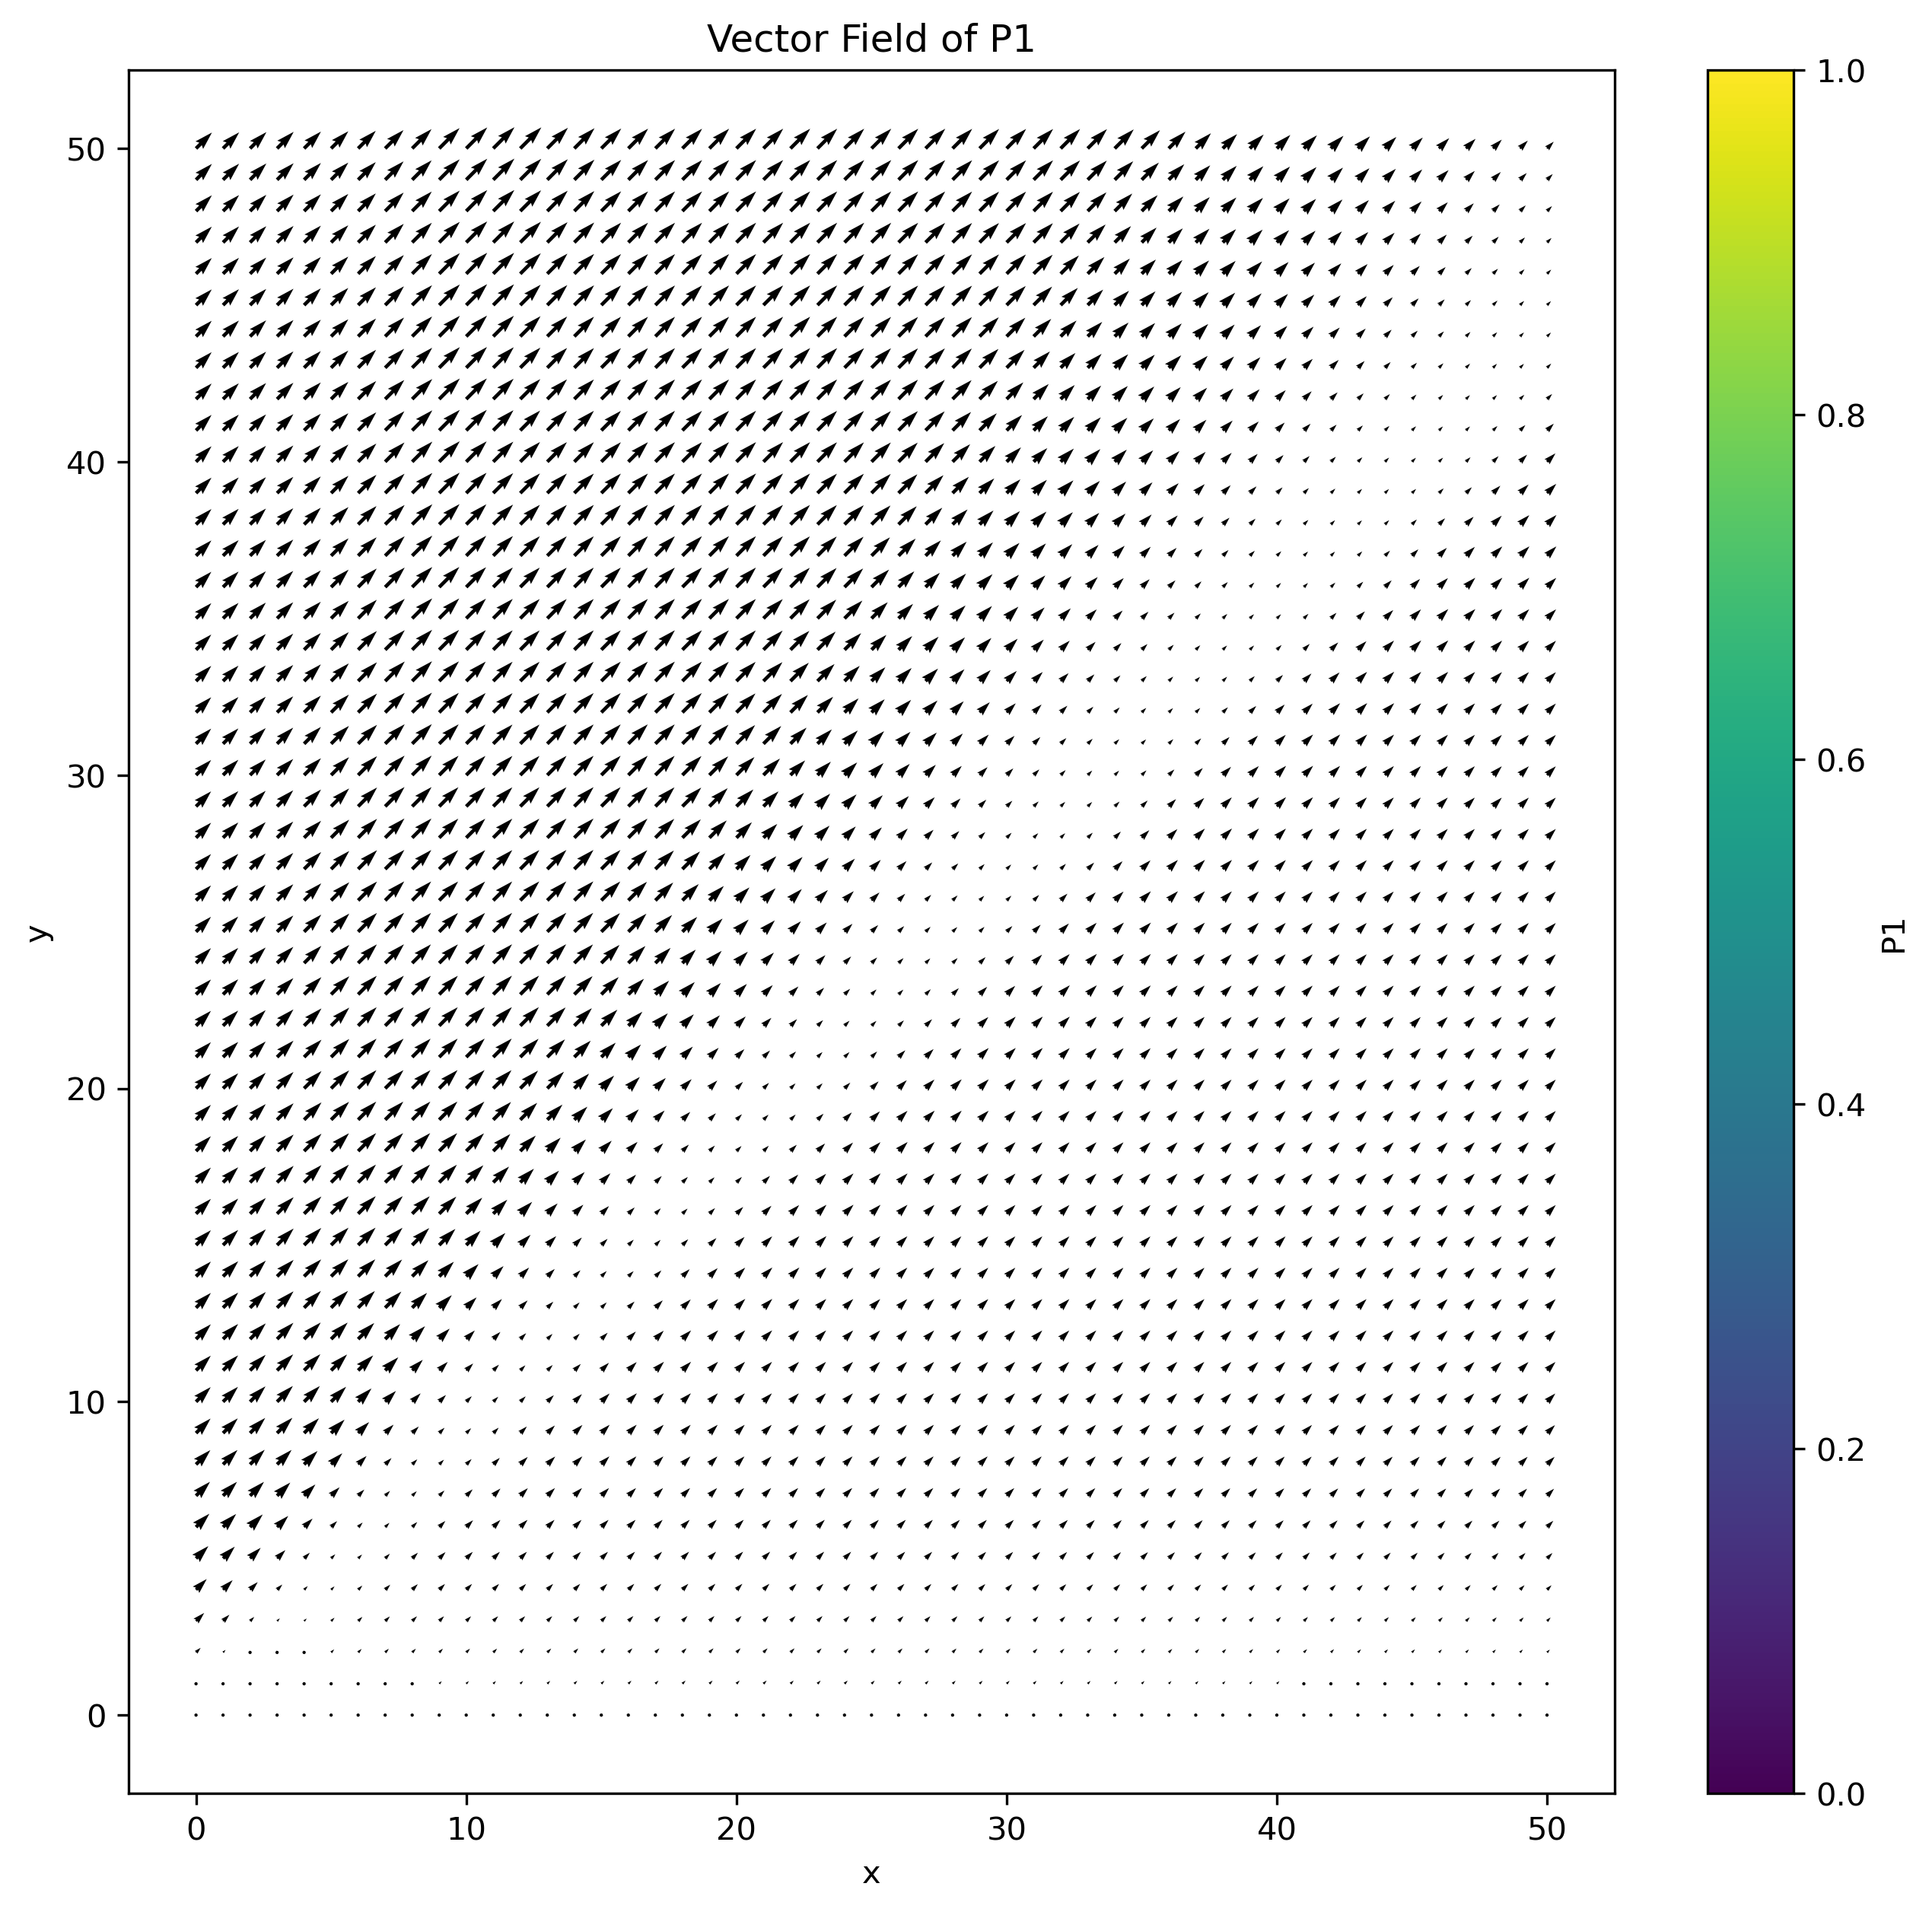

In [55]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 加载pred.mat文件
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']

# 创建网格坐标
x = data['x']
y = data['y']
X, Y = np.meshgrid(x, y)

# 计算矢量的大小和方向
U = P1_pred * np.cos(P1_pred)
#V = P1_pred * np.sin(P1_pred)

# 绘制矢量场图
plt.figure(figsize=(10.5, 10), dpi=300)
plt.quiver(X, Y, U, P1_pred, cmap='viridis')
plt.colorbar(label='P1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P1')
plt.show()


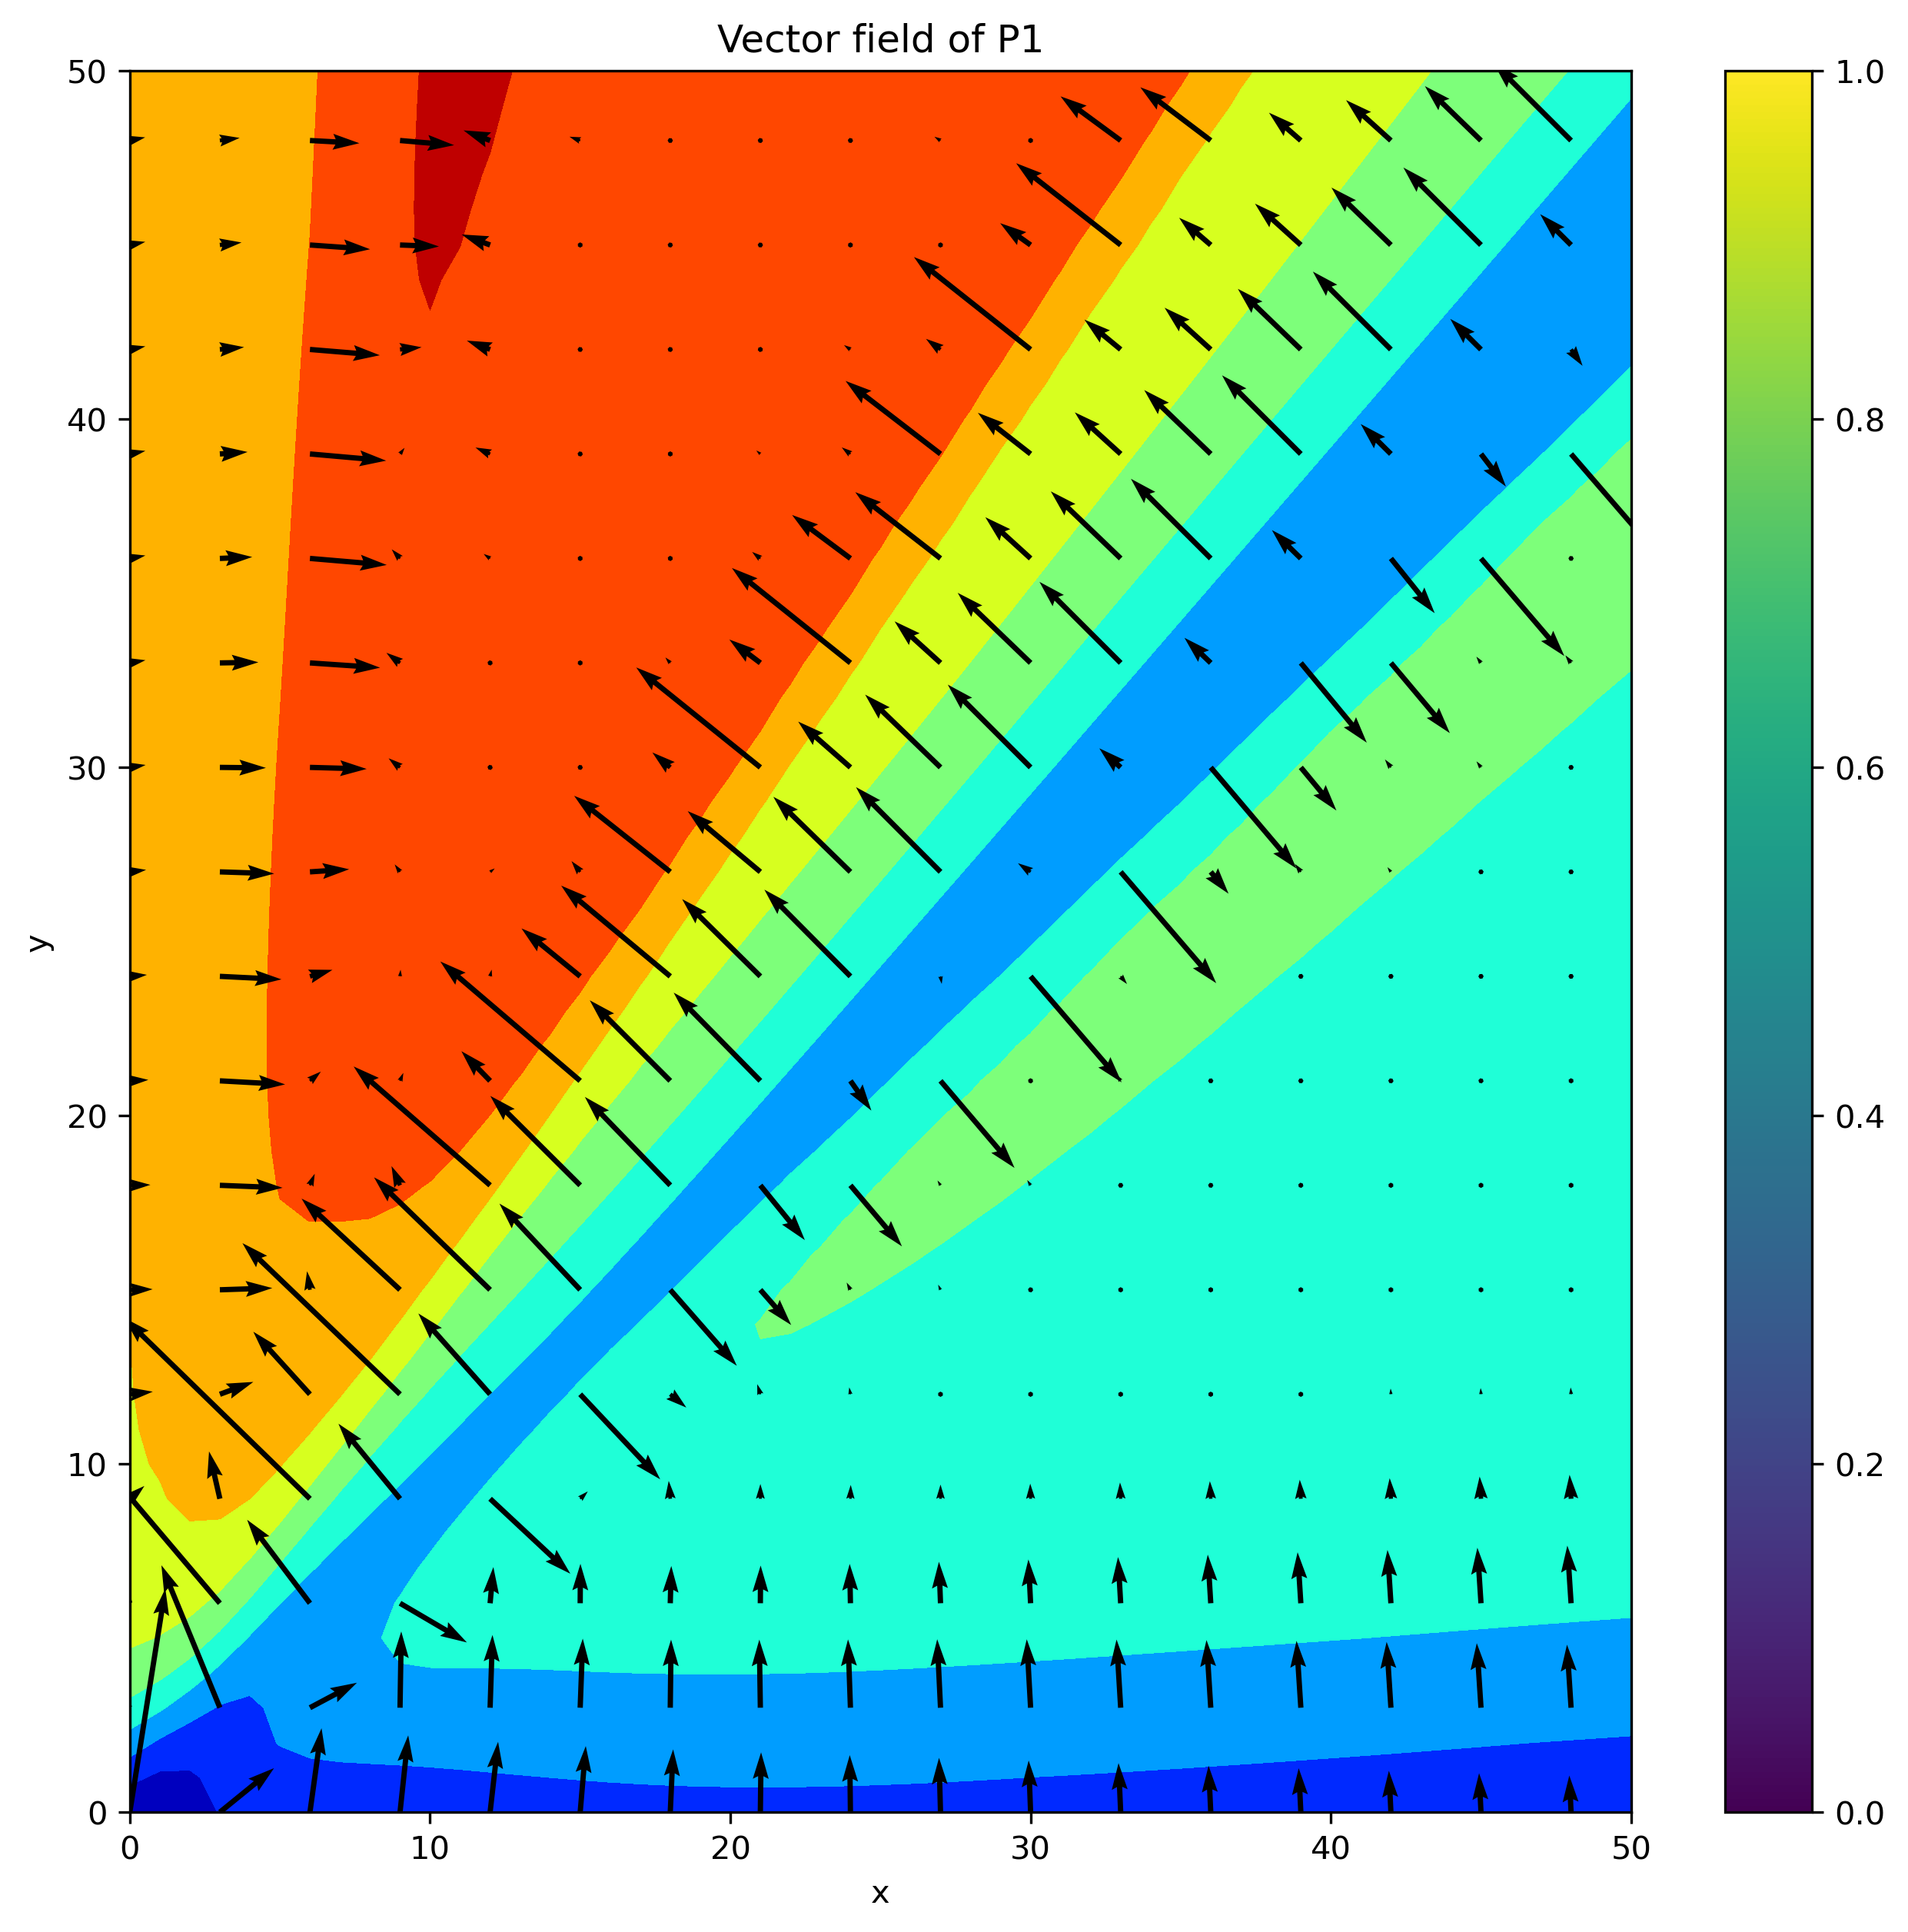

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P1, dx, axis=1)
v = np.gradient(P1, dy, axis=0)
vmag = np.sqrt(u ** 2 + v ** 2)

# 绘制矢量场图
plt.figure(figsize=(10.5, 10), dpi=300)
plt.contourf(x, y, P1, cmap='jet')
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
X, Y = np.meshgrid(x[::quiverSkip], y[::quiverSkip])
U = u[::quiverSkip, ::quiverSkip]
V = v[::quiverSkip, ::quiverSkip]
plt.quiver(X, Y, U, V)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field of P1')
plt.show()


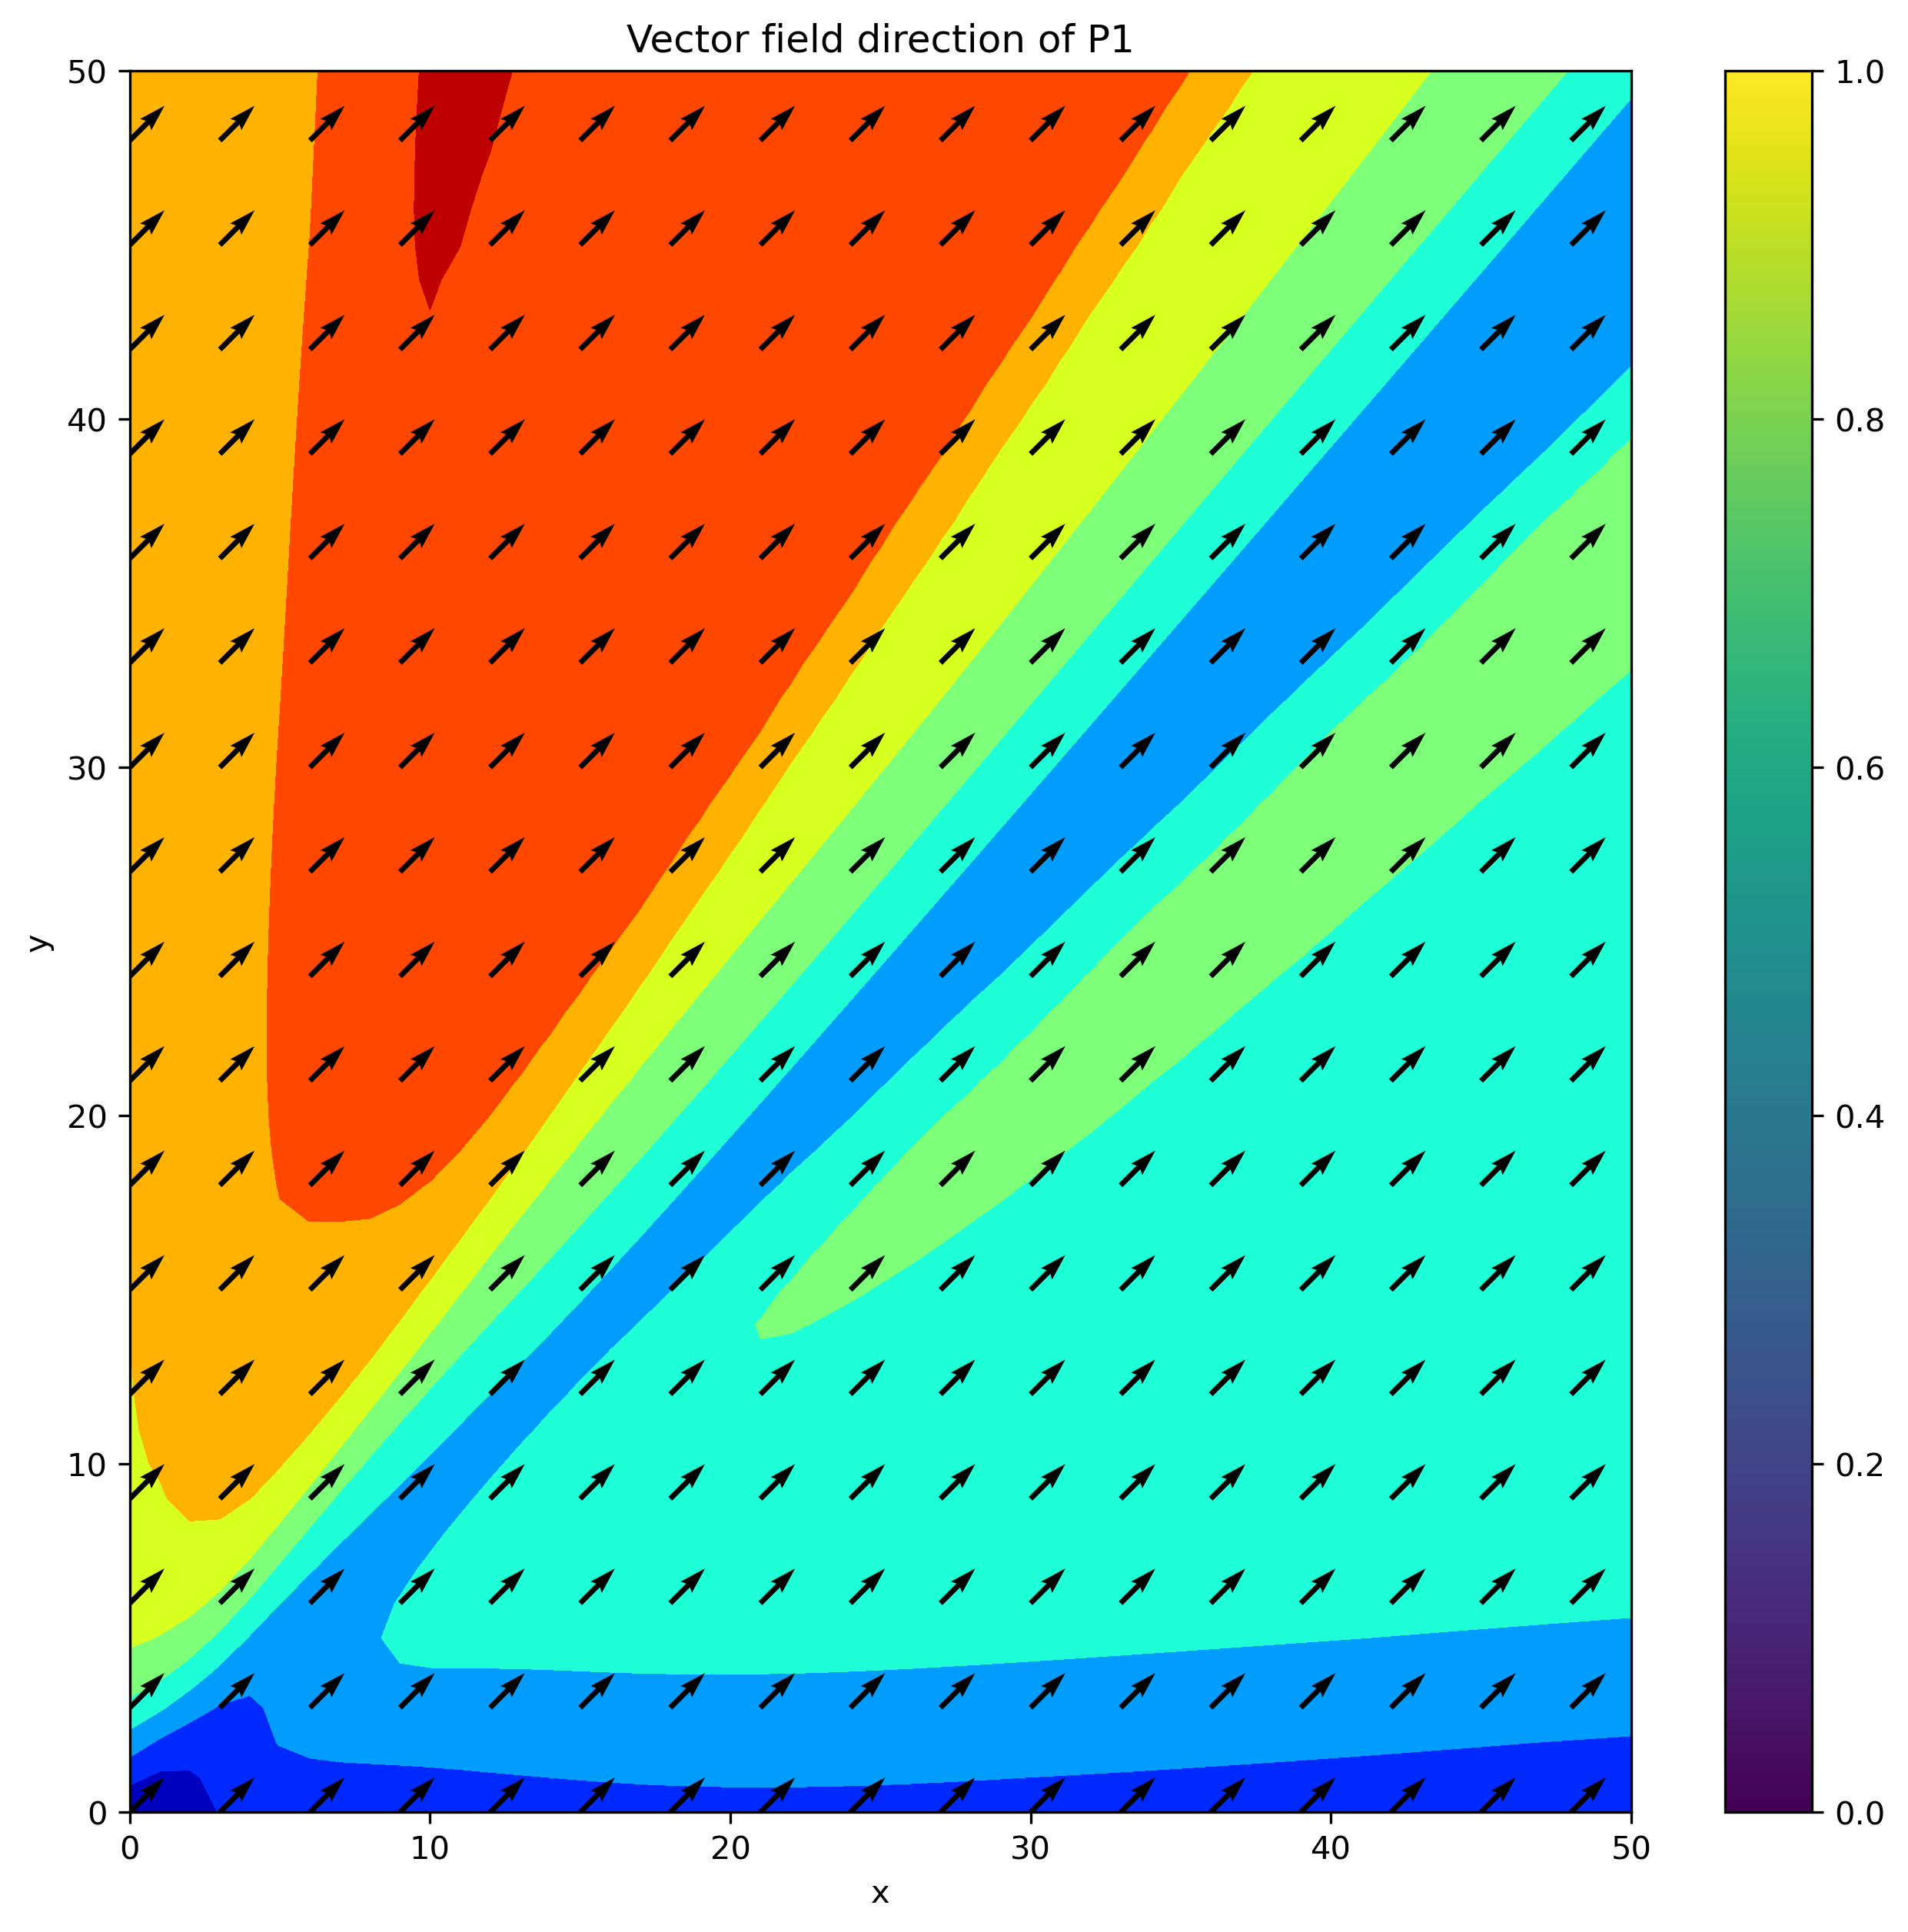

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P1, dx, axis=1)
v = np.gradient(P1, dy, axis=0)
vmag = np.sqrt(u ** 2 + v ** 2)

# 绘制矢量场图
plt.figure(figsize=(10.5, 10), dpi=300)
plt.contourf(x, y, P1, cmap='jet')
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
X, Y = np.meshgrid(x[::quiverSkip], y[::quiverSkip])
U = np.ones_like(X)
V = np.ones_like(Y)
plt.quiver(X, Y, U, V)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field direction of P1')
plt.show()


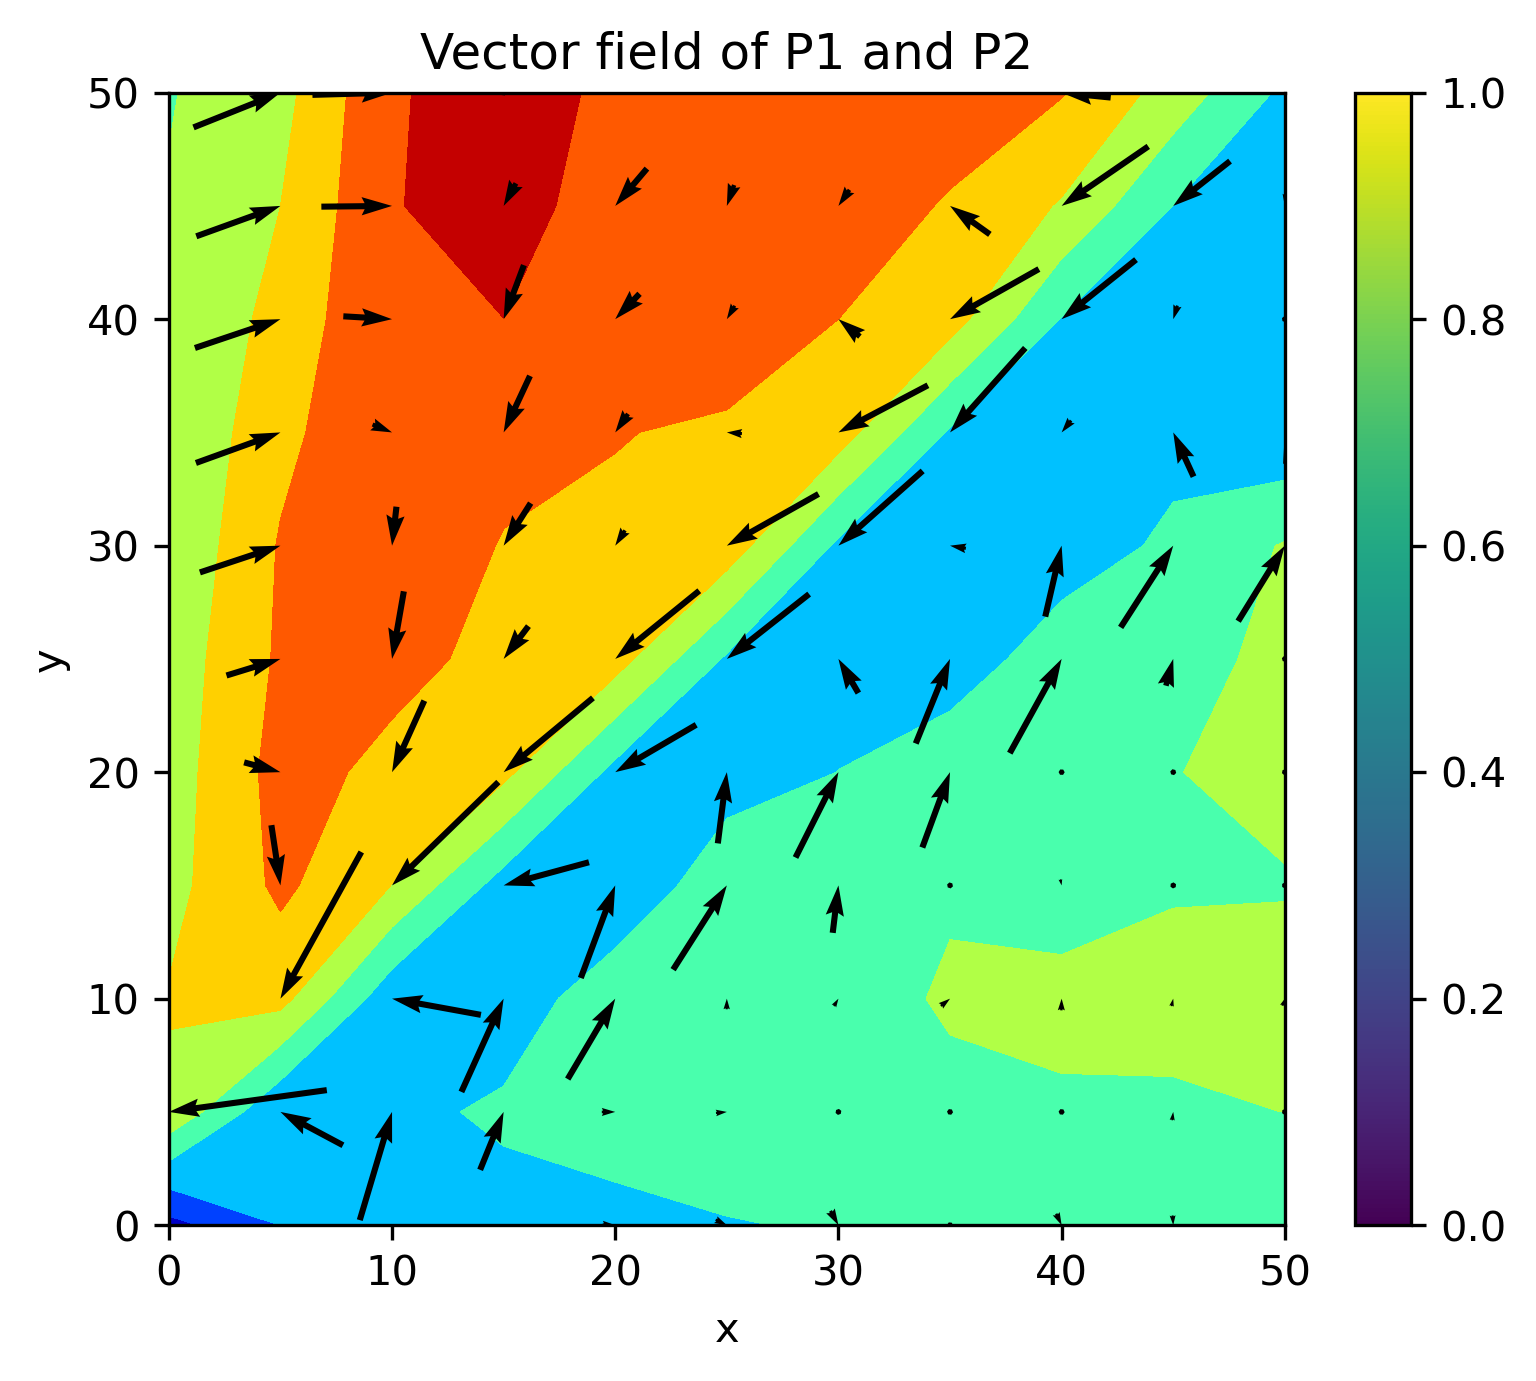

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']
P2 = data['P2']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P1, dx, axis=1)
v = np.gradient(P2, dy, axis=0)

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.contourf(x, y, P1, cmap='jet')
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
X, Y = np.meshgrid(x[::quiverSkip], y[::quiverSkip])
U = u[::quiverSkip, ::quiverSkip]
V = v[::quiverSkip, ::quiverSkip]
plt.quiver(X, Y, U, V, pivot='tip')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field of P1 and P2')
plt.show()


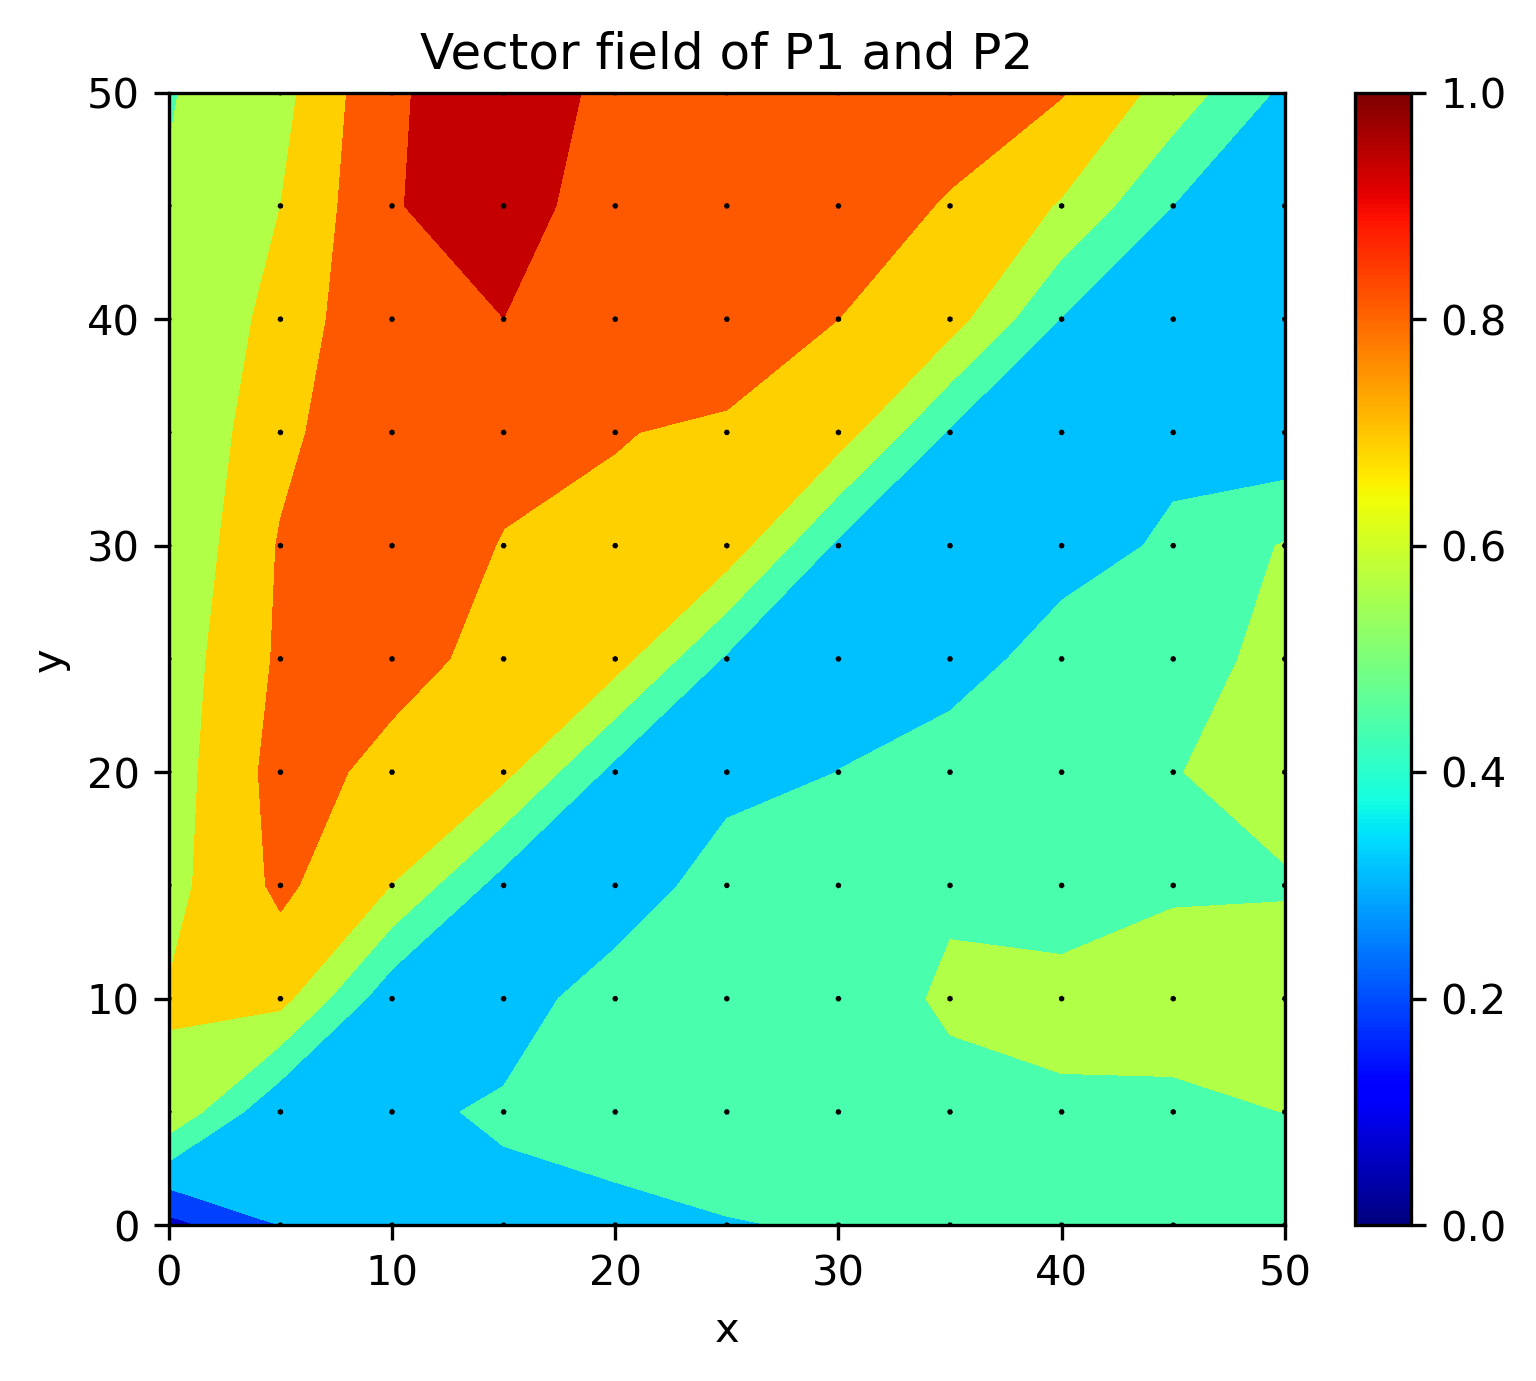

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']
P2 = data['P2']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P1, dx, axis=1)
v = np.gradient(P2, dy, axis=0)

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.contourf(x, y, P1, cmap='jet')
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
X, Y = np.meshgrid(x[::quiverSkip], y[::quiverSkip])
U = u[::quiverSkip, ::quiverSkip]
V = v[::quiverSkip, ::quiverSkip]
scale = 0.1  # 调整箭头的大小
plt.quiver(X, Y, U, V, pivot='mid', scale=scale, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field of P1 and P2')
plt.show()

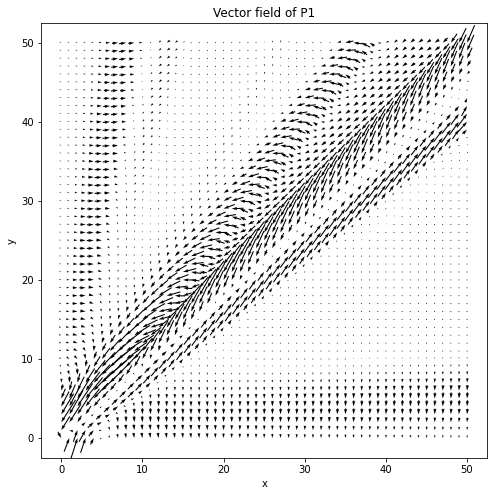

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']
P2 = data['P2']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P1, dx, axis=1)
v = np.gradient(P2, dy, axis=0)

# 绘制矢量场图
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v, pivot='tip', scale_units='xy')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field of P1')
plt.show()


C:\Users\27869\.conda\envs\pytorch\lib\site-packages\matplotlib\quiver.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\27869\.conda\envs\pytorch\lib\site-packages\matplotlib\quiver.py:686: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


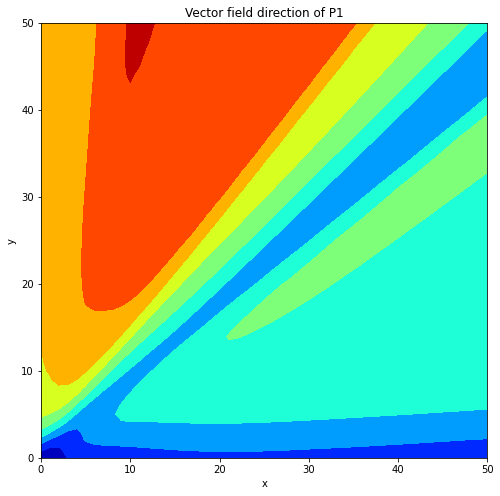

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']
P2 = data['P2']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P1, dx, axis=1)
v = np.gradient(P1, dy, axis=0)

# 绘制矢量场图
plt.figure(figsize=(8, 8))
plt.contourf(x, y, P1, cmap='jet')
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
X, Y = np.meshgrid(x[::quiverSkip], y[::quiverSkip])
U = np.zeros_like(X)
V = np.zeros_like(Y)
plt.quiver(X, Y, U, V, pivot='mid', color='white', scale_units='xy')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field direction of P1')
plt.show()


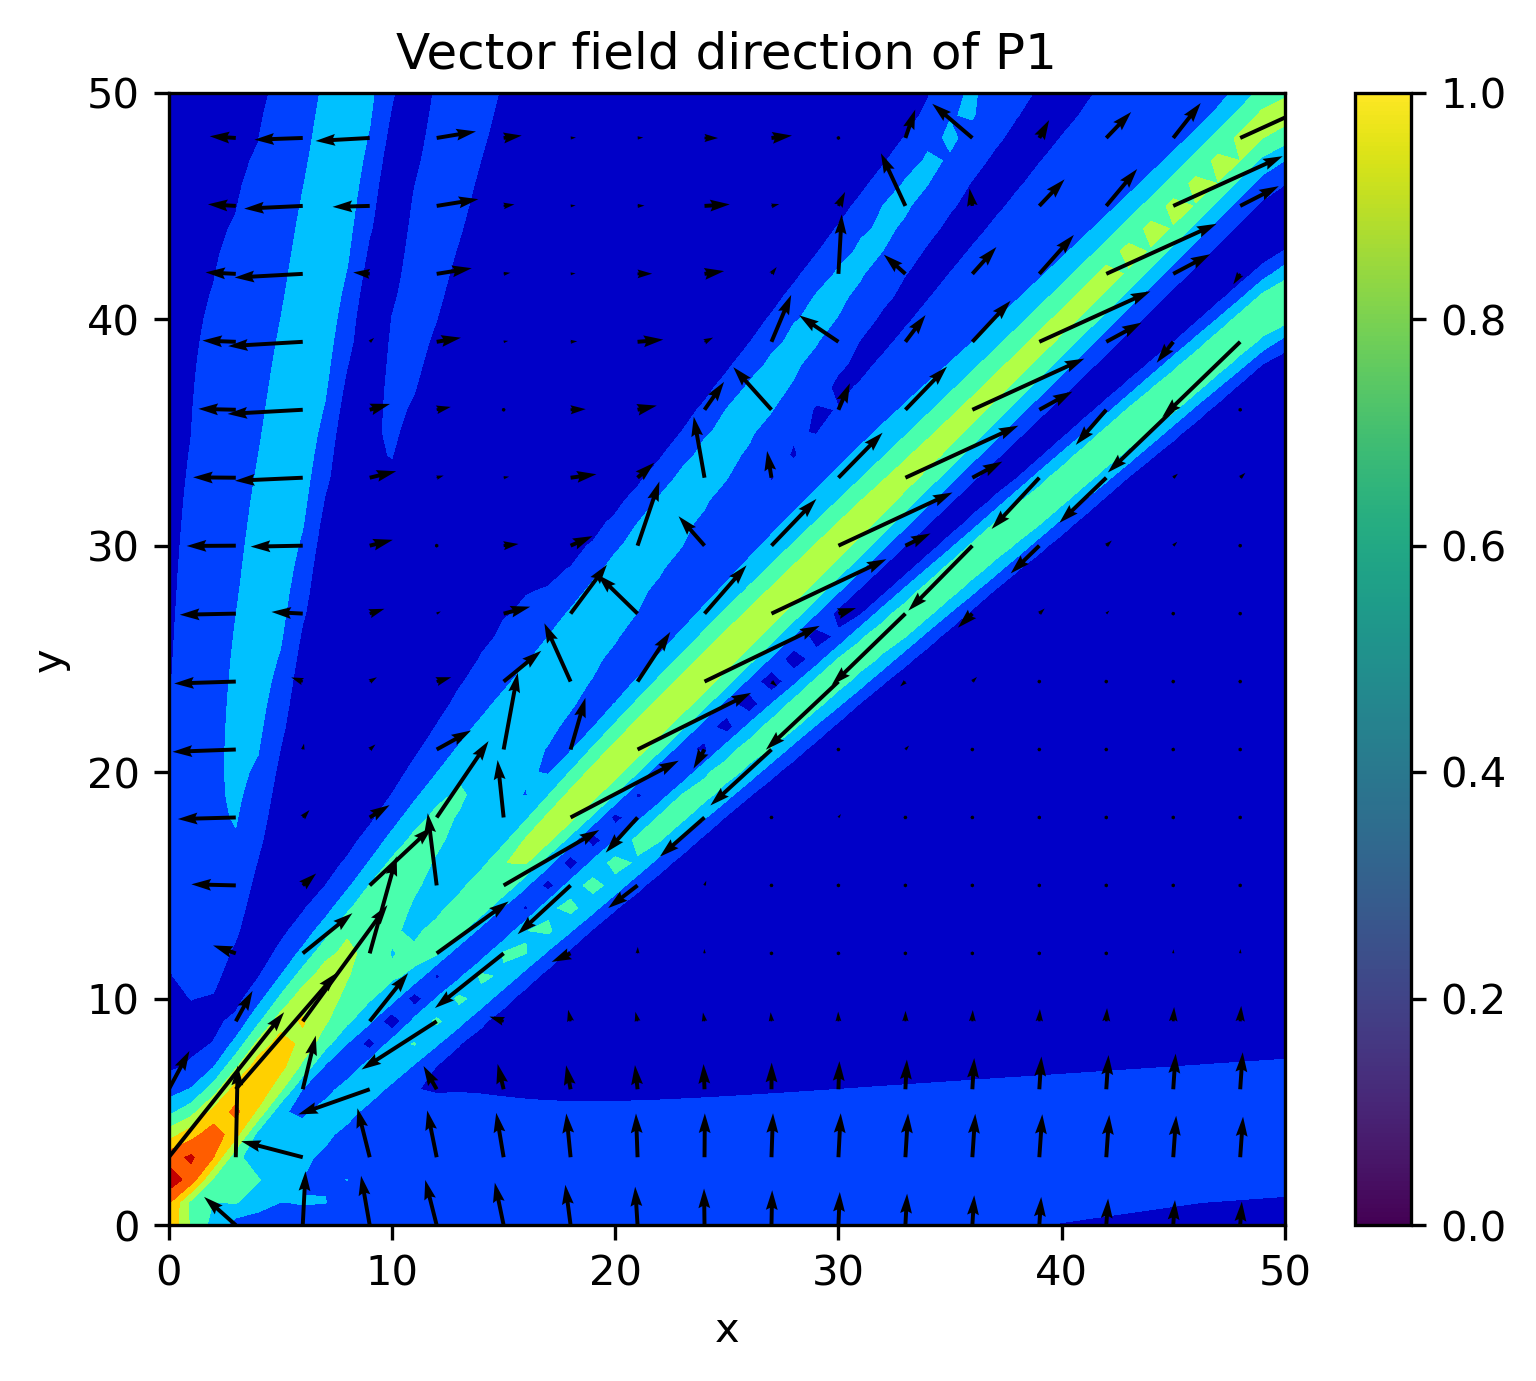

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# 读取pred.mat文件
data = scipy.io.loadmat('pred.mat')
x = data['x'].flatten()
y = data['y'].flatten()
P1 = data['P1']
P2 = data['P2']

# 计算属性
dx = x[1] - x[0]
dy = y[1] - y[0]
u = np.gradient(P2, dx, axis=1)
v = np.gradient(P1, dy, axis=0)
vmag = np.sqrt(u ** 2 + v ** 2)

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.contourf(x, y, vmag, cmap='jet')
quiverSkip = max(1, np.round(len(x) / 20).astype(np.int))
X, Y = np.meshgrid(x[::quiverSkip], y[::quiverSkip])
U = u[::quiverSkip, ::quiverSkip]
V = v[::quiverSkip, ::quiverSkip]
plt.quiver(X, Y, U, V)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector field direction of P1')
plt.show()


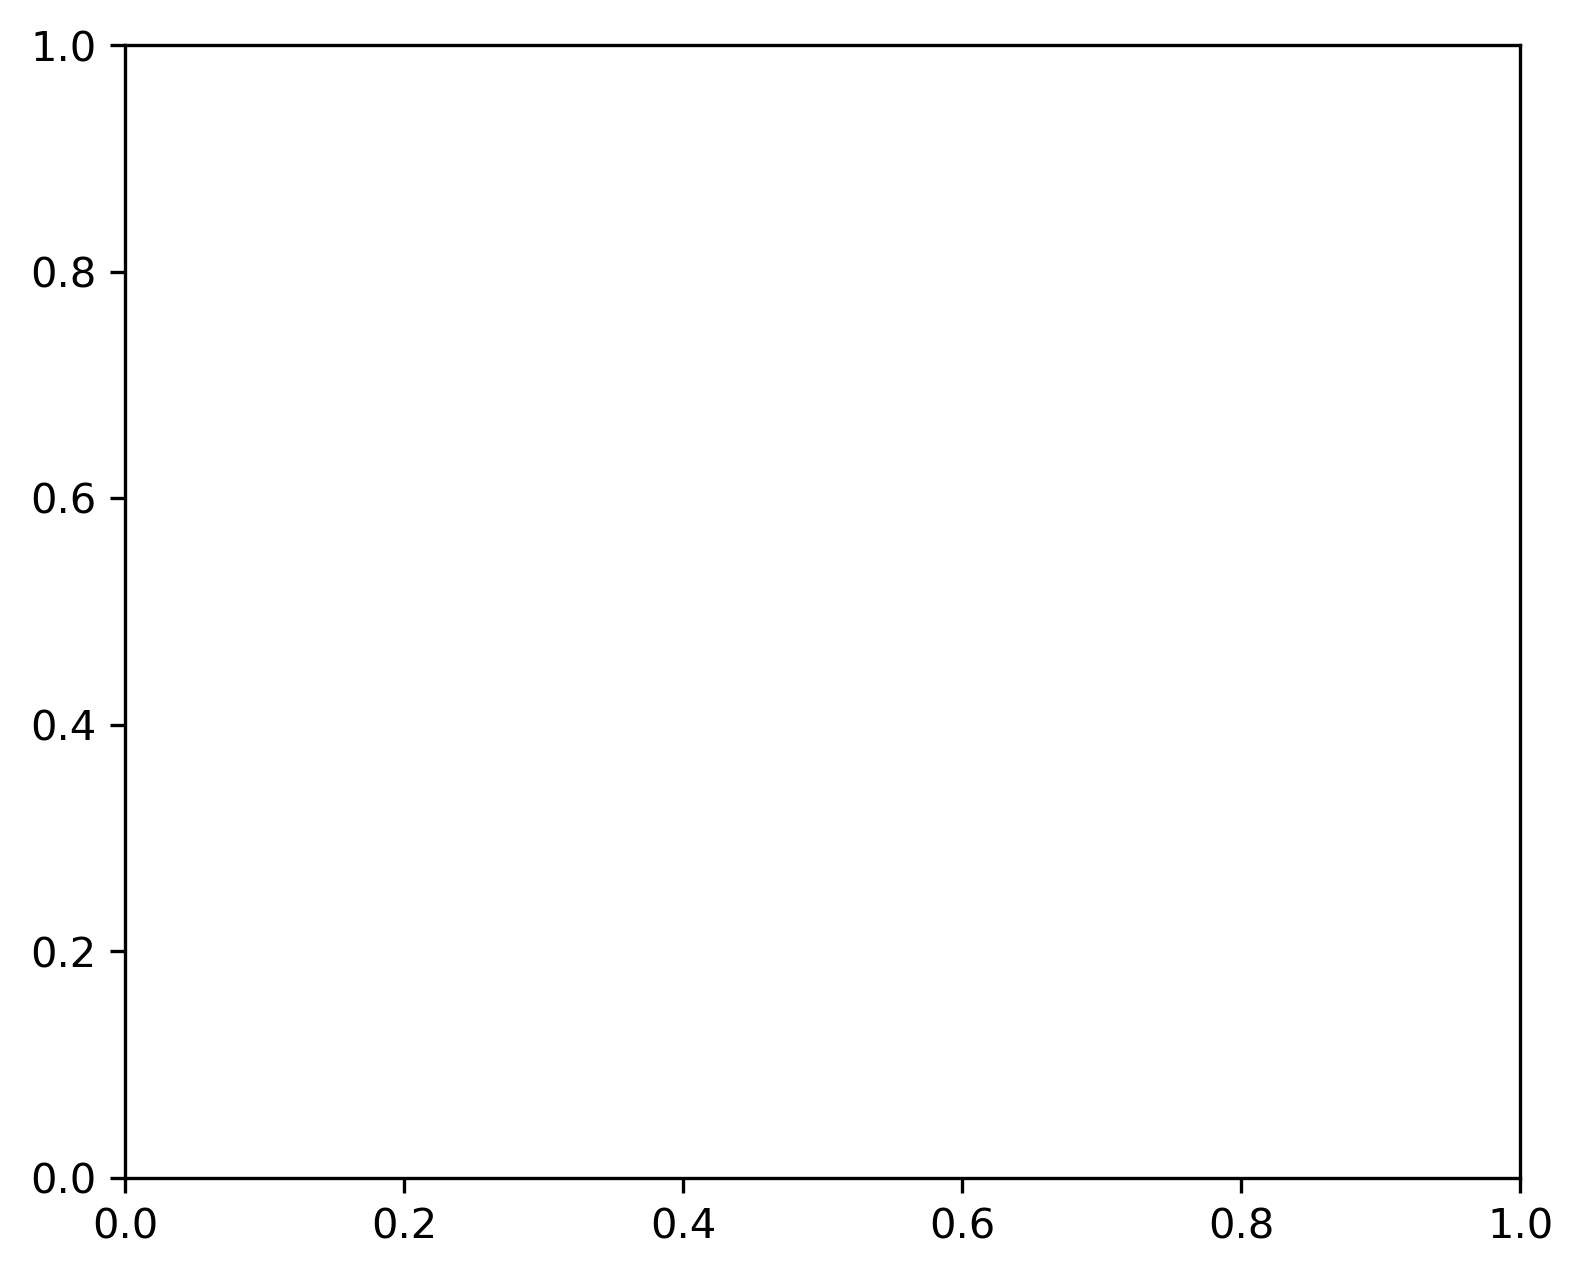

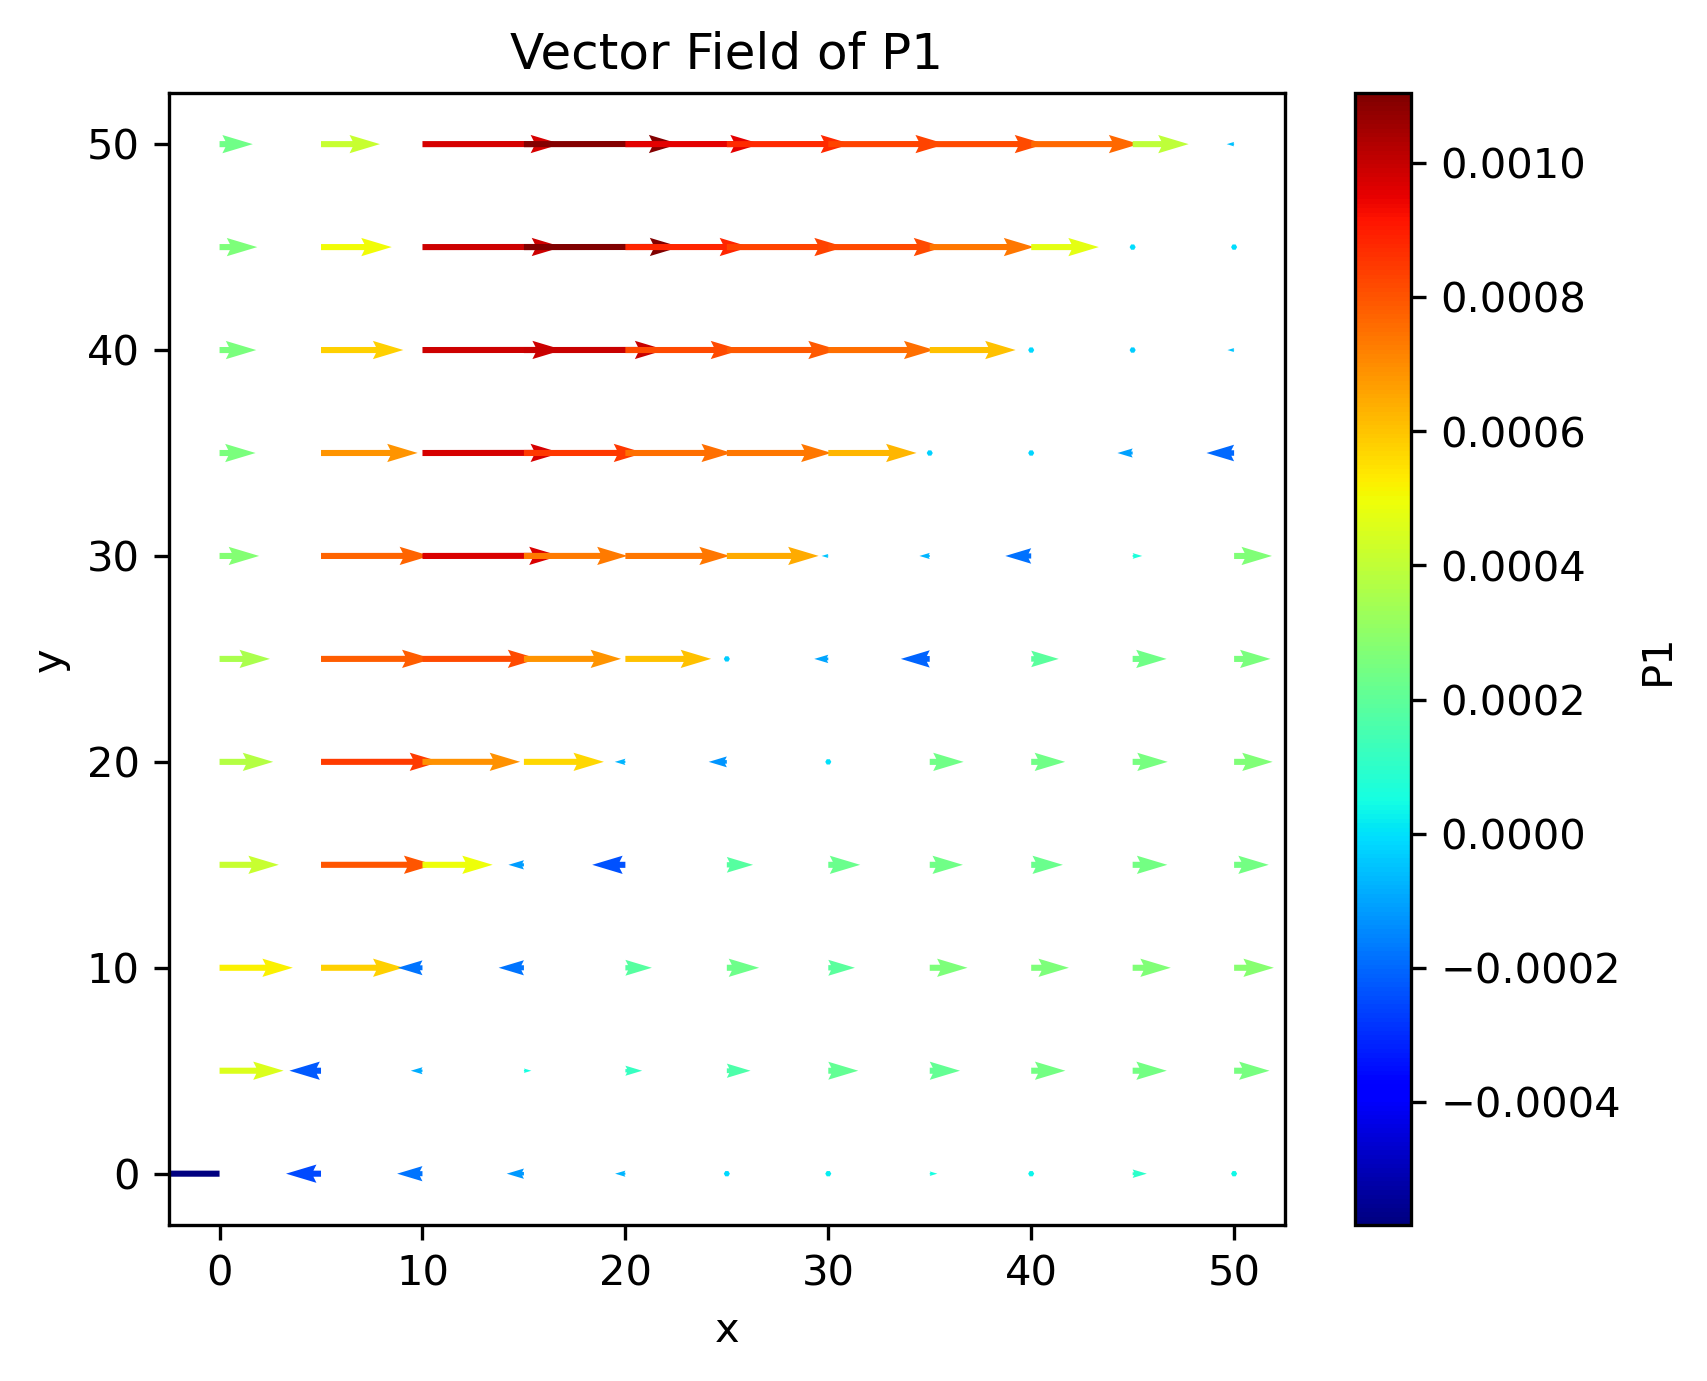

In [108]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 读取预测数据
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']  # 假设P1的形状为(51, 51)

# 创建网格
x = np.linspace(0, 50, 11)
y = np.linspace(0, 50, 11)
X, Y = np.meshgrid(x, y)

# 创建箭头的坐标和方向
U = P1_pred * np.cos(P1_pred)
V = P1_pred * np.sin(P1_pred)

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.quiver(X, Y, U, V, P1_pred, cmap='jet')
plt.colorbar(label='P1')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P1')
plt.show()


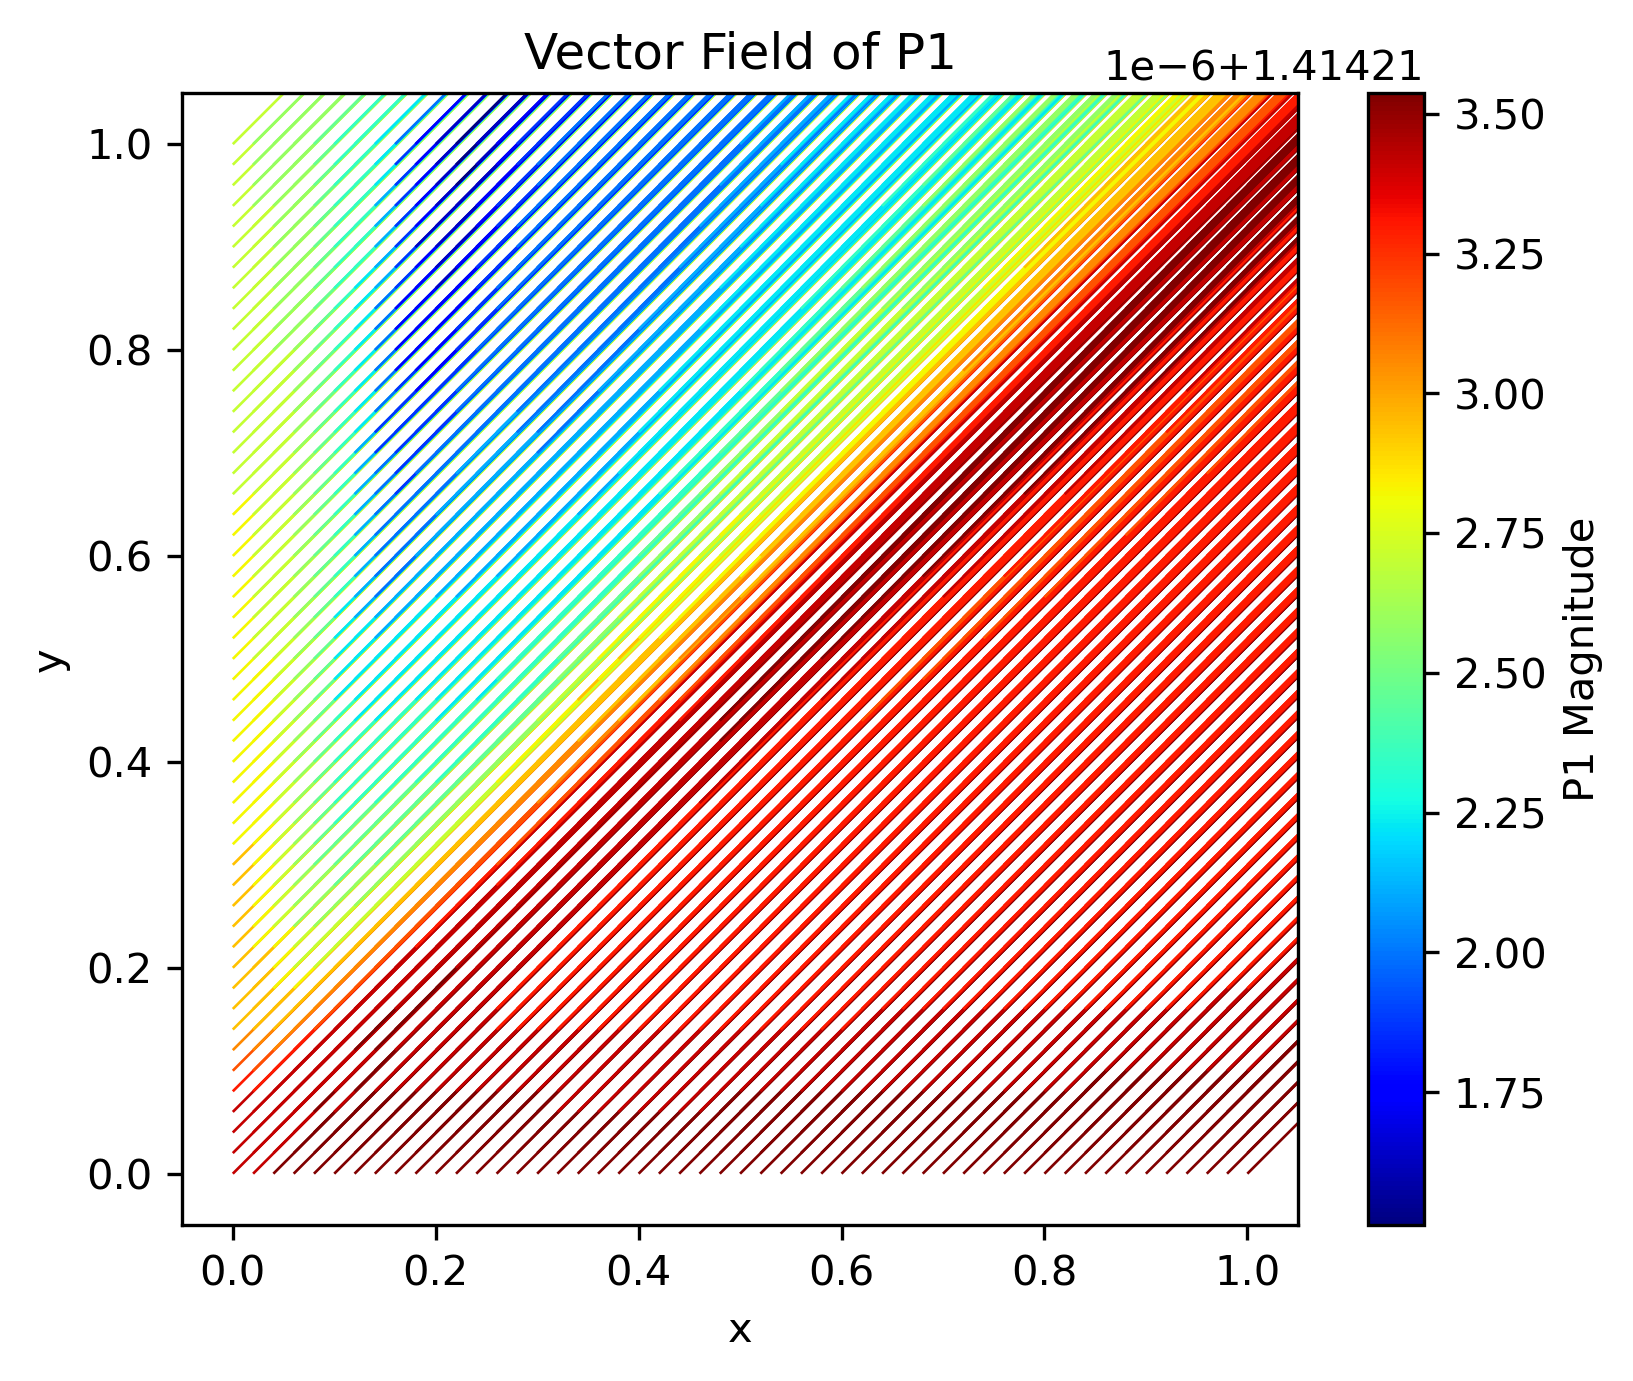

In [74]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 读取预测数据
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']
P2_pred = data['P2']

# 创建网格
x = np.linspace(0, 1, 51)
y = np.linspace(0, 1, 51)
X, Y = np.meshgrid(x, y)

# 设置箭头大小
scale = 0.05

# 计算箭头的方向
U = np.cos(P1_pred)
V = np.cos(P2_pred)

# 计算箭头的长度（大小）
magnitude = np.sqrt(U**2 + V**2)

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.quiver(X, Y, U, V, magnitude, cmap='jet', scale=scale)
plt.colorbar(label='P1 Magnitude')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P1')
plt.show()


In [90]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 读取预测数据
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']  # 假设P1的形状为(51, 51)
P2_pred = data['P2']
# 创建网格
x = np.linspace(0, 50, 51)
y = np.linspace(0, 50, 51)
X, Y = np.meshgrid(x, y)

# 计算矢量大小和方向
magnitude = np.sqrt(P1_pred ** 2 + P2_pred ** 2)
angle = np.arctan2(P1_pred, P2_pred)

# 箭头的缩放比例
scale = 0.5  # 调整此参数以改变箭头的大小

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.quiver(X, Y, np.cos(angle), np.sin(angle), magnitude, cmap='jet', scale=scale)
plt.colorbar(label='Magnitude')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P')
plt.show()


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


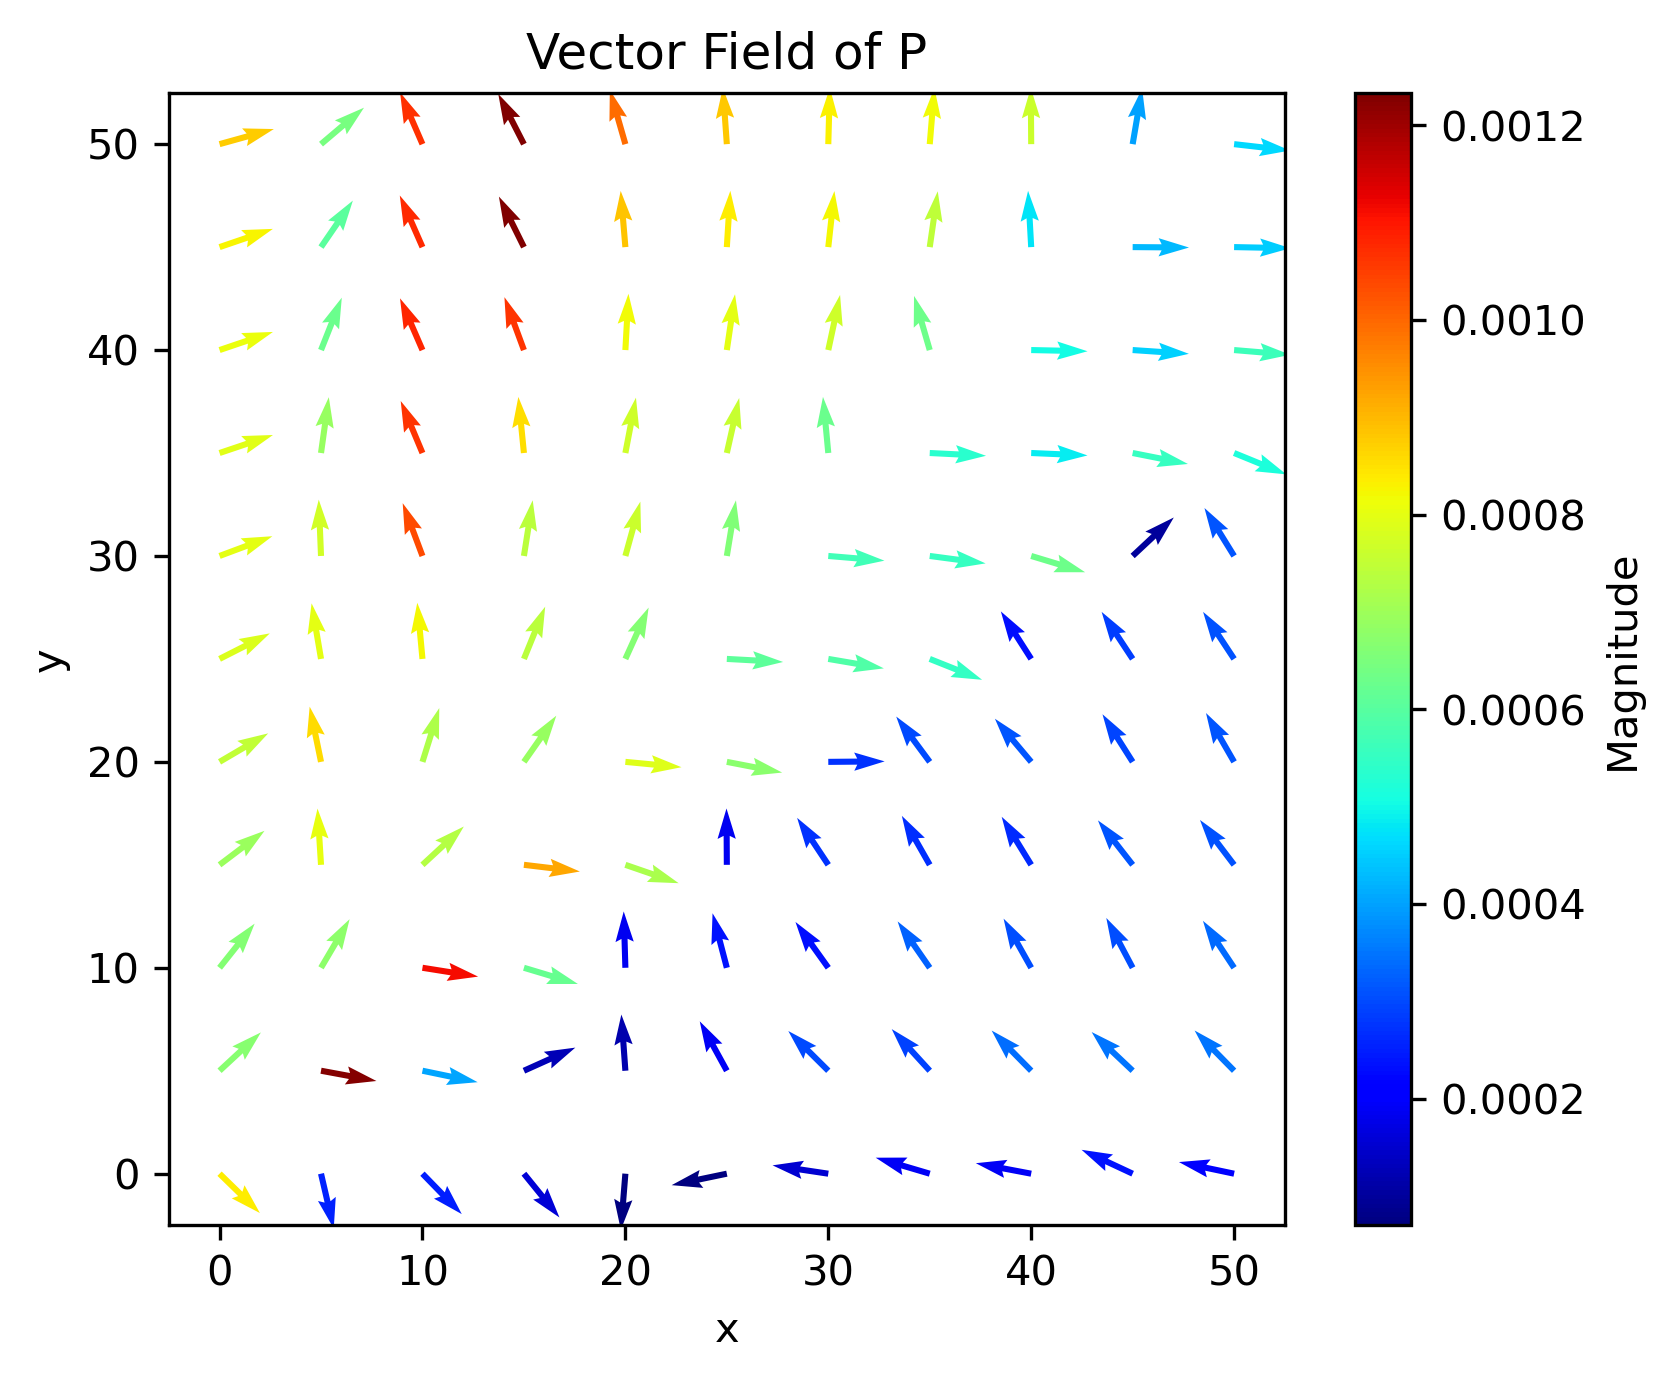

In [97]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 读取预测数据
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']  # 假设P1的形状为(51, 51)
P2_pred = data['P2']
# 创建网格
x = np.linspace(0, 50, 11)
y = np.linspace(0, 50, 11)
X, Y = np.meshgrid(x, y)

# 计算矢量大小和方向
magnitude = np.sqrt(P1_pred ** 2+P2_pred ** 2)
angle = np.arctan2(P1_pred, P2_pred)

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.quiver(X, Y, np.cos(angle), np.sin(angle), magnitude, cmap='jet')
plt.colorbar(label='Magnitude')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P')
plt.show()

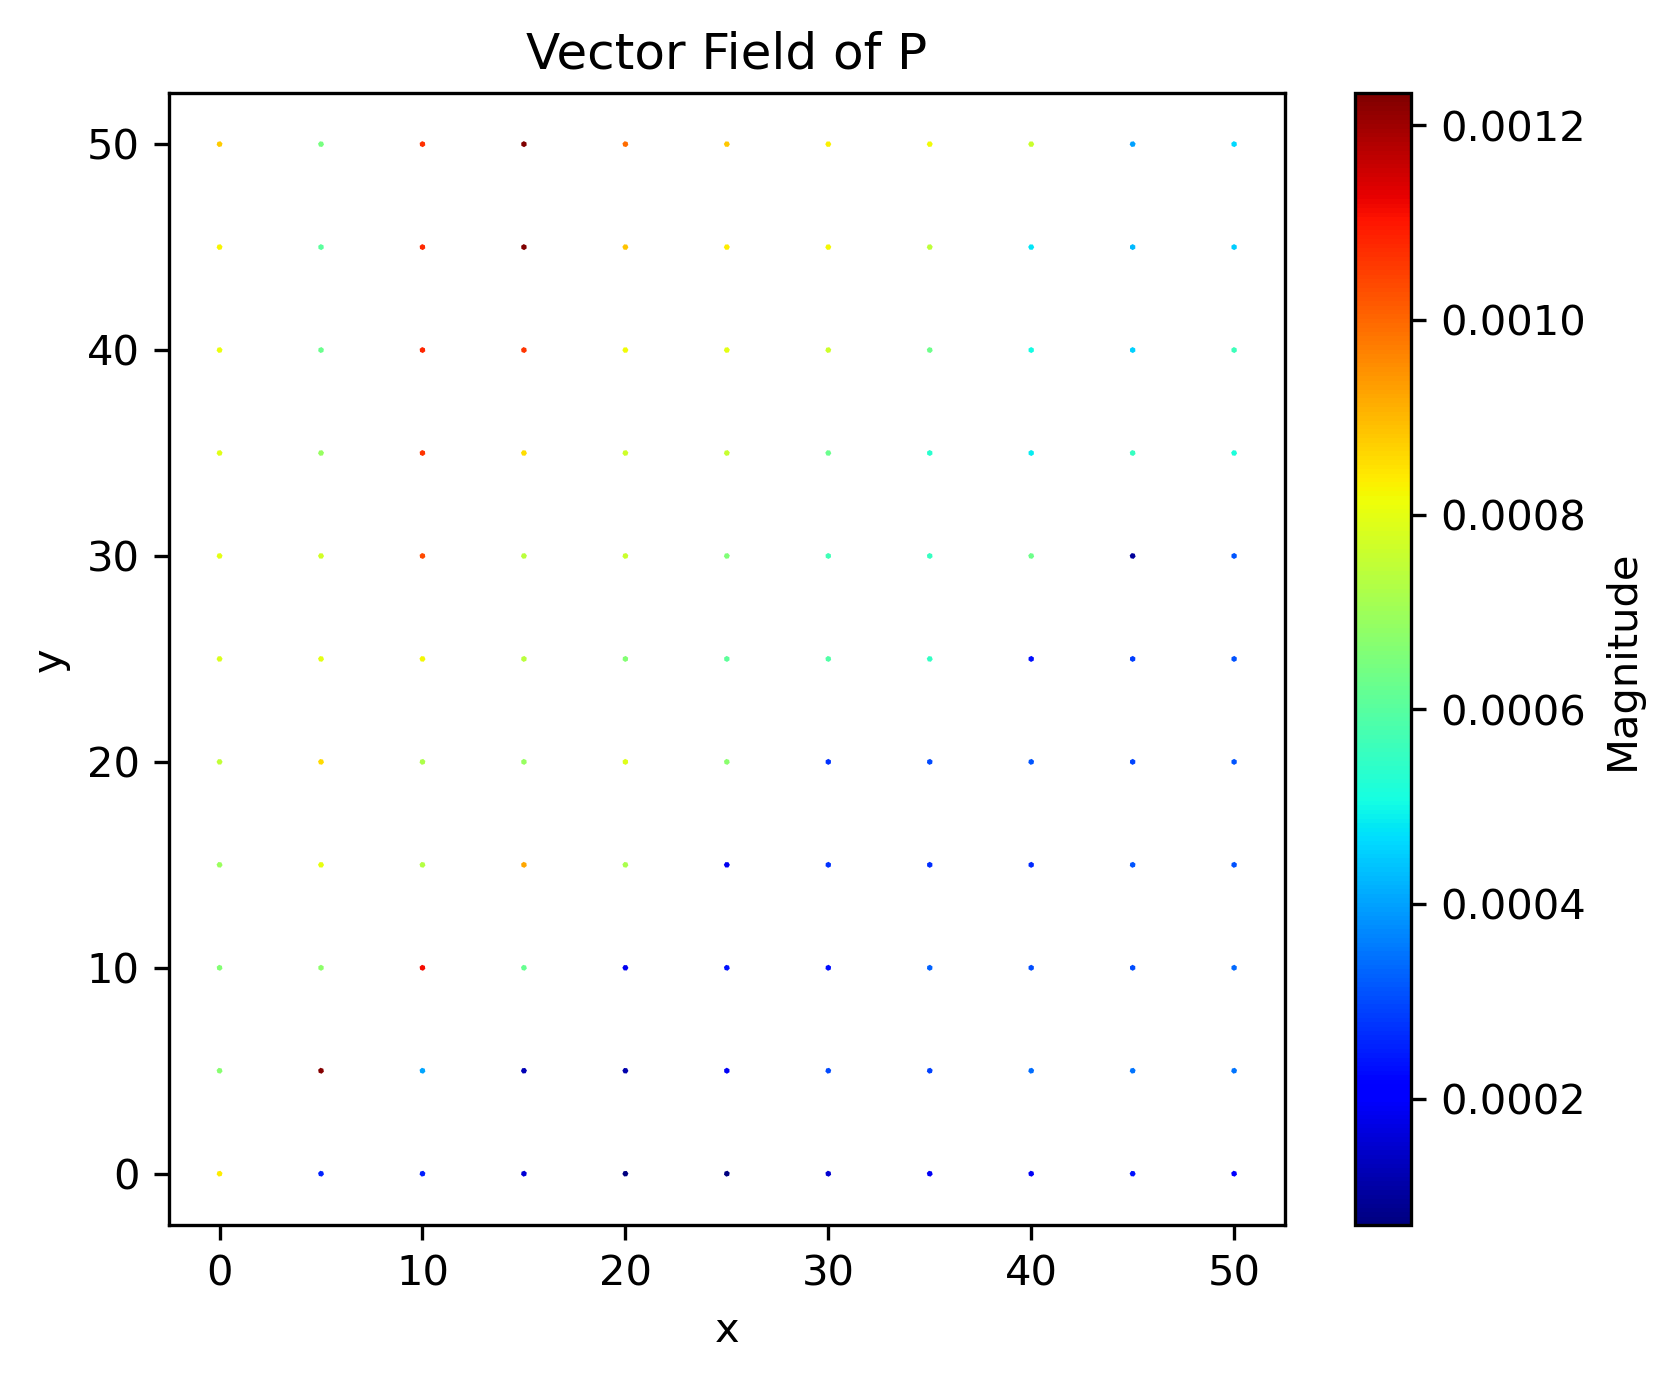

In [103]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# 读取预测数据
data = scipy.io.loadmat('pred.mat')
P1_pred = data['P1']  # 假设P1的形状为(51, 51)
P2_pred = data['P2']
# 创建网格
x = np.linspace(0, 50, 11)
y = np.linspace(0, 50, 11)
X, Y = np.meshgrid(x, y)

# 计算矢量大小和方向
magnitude = np.sqrt(P1_pred ** 2 + P2_pred ** 2)
angle = np.arctan2(P2_pred, P1_pred)

# 设置箭头的大小
scale = 5

# 绘制矢量场图
plt.figure(figsize=(6, 5), dpi=300)
plt.quiver(X, Y, P1_pred, P2_pred, magnitude, angles='xy', scale_units='xy', scale=scale, cmap='jet')
plt.colorbar(label='Magnitude')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of P')
plt.show()


In [2]:
import torch
pt = torch.load('LBFGS_sqloss.pt')